# MACHINE LEARNING PROJECT : NASA PREDICTIVE MAINTENANCE RUL

#### HUYNH Nicolas - HONG Lucka - HASSENFORDER Léo - MMN3

# Introduction

During their lifetime, aircraft components are susceptible to **degradation**, which affects directly their **reliability and performance**.
This machine learning project will be directed to provide a framework for **predicting the aircraft’s remaining useful life (RUL)** based on the entire life cycle data in order to provide the necessary maintenance behavior. **Diverse regression, classification models (Random Forest, SVM and LSTM)** are deployed and tested on the NASA’s C-MAPSS data-set to assess the engine’s lifetime. 

Here is the description and technical presentation of an engine that we are going to study : 

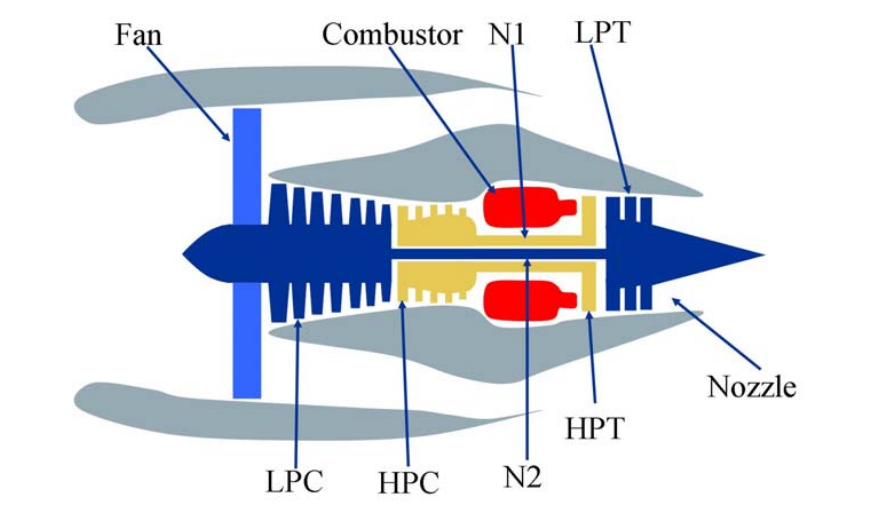

# ****PART 1****. Importation of libraries, Dataset Analysis and Preprocessing

### a) Import Libraries

First, let's import all the necessary libraries for this machine learning project : sklearn and tensorflow.

In [ ]:
# Install with pip if not installed 
#!pip install tensorflow
#!pip install keras_tuner

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import seaborn as sns

#matplotlib for vizualisations
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


# Scikit-learn for preprocessing with minmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #score results
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor #Model 1 : Random Forest

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# KerasTuner for hyperparameter optimization
import keras_tuner as kt

sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-pastel')

Libraries imported.


### b) Load the Datasets

Now, we will load the dataset files, with the train, test and RUL, RUL being the validation one.

In [ ]:
train = 'train_FD001.txt'
test = 'test_FD001.txt'
rul = 'RUL_FD001.txt'

#Create dataframe with pandas
train_df = pd.read_csv(train, sep=' ', header=None)
test_df = pd.read_csv(test, sep=' ', header=None)
truth_df = pd.read_csv(rul, sep=' ', header=None)

Data loaded.


### c) 1st Dataframe Visualisation

Let's visualise the **raw** dataframe.

####  i) **Training** DataSet


In [ ]:
#first 5 rows of the train data

#n_engines = train_df['engine_id'].nunique()

train_df.head()


0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]

The training dataset consists of complete run-to-failure sensor trajectories for **n_engines** aircraft engines, capturing the full degradation process from a healthy state up to the point of failure.

In [6]:
print(f"Train dataset shape: {train_df.shape}")

Train dataset shape: (20631, 28)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

We can see missing values (NaN) and columns are not named

#### ii) **Test** Dataset


In [8]:
# First 5 rows of the test data
test_df.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1   2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1   3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1   4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1   5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8125.55  8.4052  0.03  392  2388  100.0  38.86  23.3735 NaN NaN  
1  ...  8139.62  8.3803  0.03  393  2388  100.0  39.02  23.3916 NaN NaN  
2  ...  8130.10  8.4441  0.03  393  2388  100.0  39.08  23.4166 NaN NaN  
3  ...  8132.90  8.3917  0.03  391  2388  100.0  39.00  23.3737 NaN NaN  
4  ...  8129.54  8.4031  0.03  390  2388  100.0  38.99  23.4130 NaN NaN  

[5 rows x 28 columns]

In [ ]:
print(f"Test dataset shapeis : {test_df.shape}")

Test dataset shape: (13096, 28)


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       13096 non-null  int64  
 1   1       13096 non-null  int64  
 2   2       13096 non-null  float64
 3   3       13096 non-null  float64
 4   4       13096 non-null  float64
 5   5       13096 non-null  float64
 6   6       13096 non-null  float64
 7   7       13096 non-null  float64
 8   8       13096 non-null  float64
 9   9       13096 non-null  float64
 10  10      13096 non-null  float64
 11  11      13096 non-null  float64
 12  12      13096 non-null  float64
 13  13      13096 non-null  float64
 14  14      13096 non-null  float64
 15  15      13096 non-null  float64
 16  16      13096 non-null  float64
 17  17      13096 non-null  float64
 18  18      13096 non-null  float64
 19  19      13096 non-null  float64
 20  20      13096 non-null  float64
 21  21      13096 non-null  int64  
 22

####  iii) Ground Truth Data
Ground truth data refers to verified, true data used for training, validating and testing artificial intelligence models.

In [11]:
# Display the first 20 rows
truth_df.head(20).T

0     1     2     3     4     5     6     7      8     9     10     11  \
0  112.0  98.0  69.0  82.0  91.0  93.0  91.0  95.0  111.0  96.0  97.0  124.0   
1    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN    NaN   

     12     13    14    15    16    17    18    19  
0  95.0  107.0  83.0  84.0  50.0  28.0  87.0  16.0  
1   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [ ]:
print(f"Truth dataset shape is: {truth_df.shape}")

Truth dataset shape: (100, 2)


### d) Pre processing : Dataset **cleaning** and **formalization**
The raw data comes without column names and often includes extra empty columns at the end due to trailing spaces in the files. We'll clean this up by dropping any unnecessary columns and assigning descriptive names. Using errors='ignore' makes our code robust, as it won't fail if the extra columns aren't present.

For the moment we will keep generic names with sensor_i, but later they will be named via the Kaggle documentation.



#### i) Missing Values

In [ ]:
# Missing values
print("Missing values in train dataset are:")
print(train_df.isna().sum())

print("\nMissing values in test dataset are :")
print(test_df.isna().sum())

print("\nMissing values in the ground truth are:")
print(truth_df.isna().sum())

Missing values in train dataset :
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64

Missing values in test dataset :
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    13096
27    13096
dtype: int64

Missing values in the ground truth :
0      0
1    100
dtype: int64



To ensure our datasets do not contain any missing values (`NaN`), 
we remove all rows that contain them in each dataset:


In [ ]:
# Remove columns with missing values
train_df.dropna(axis=1, how='any', inplace=True)
test_df.dropna(axis=1, how='any', inplace=True)
truth_df.dropna(axis=1, how='any', inplace=True)

print(f"Train dataframe shape is: {train_df.shape}")
print(f"Test dataframe shape is: {test_df.shape}")
print(f"Ground truth dataframe shape is: {truth_df.shape}")

Train dataframe shape: (20631, 26)
Test dataframe shape: (13096, 26)
Ground truth dataframe shape: (100, 1)

Removed columns with missing values.


#### ii) Duplicated Values

Exact duplicates can be safely removed from the training set to reduce noise, but they must be kept in the test set to preserve the temporal sequence of the time series data. 
**But we can't remove duplicates from the truth file (RUL)**, as the row index strictly corresponds to the specific engine identity and removing lines would misalign the ground truth. Moreover, having many identical values in term of RUL is not a problem, it's absolutely possible that 2 engines have the same remaining useful life.

In [ ]:
# Check for duplicate rows in the train dataset
num_duplicates_train = train_df.duplicated().sum()
print(f"Number of duplicate rows in train dataset is: {num_duplicates_train}")

# Check for duplicate rows in the test dataset
num_duplicates_test = test_df.duplicated().sum()
print(f"Number of duplicate rows in test dataset is: {num_duplicates_test}")

# Check for duplicate rows in the ground truth dataset
num_duplicates_truth = truth_df.duplicated().sum()
print(f"Number of duplicate rows in ground truth dataset is: {num_duplicates_truth}")

Number of duplicate rows in train dataset: 0
Number of duplicate rows in test dataset: 0
Number of duplicate rows in ground truth dataset: 29


In [ ]:
# We remove duplicate rows in the training dataset
train_df.drop_duplicates(inplace=True)

Duplicated values from the train dataset are now removed.


#### iii) Define generic descriptive column names for clarity

Let's formalize the dataframe with generic column names, we will in a second place explicit their real role.

In [ ]:
column_names = ['engine_id', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
    'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12',
    'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
    'sensor_19', 'sensor_20', 'sensor_21']

# Assign the column names to the train, test and truth dataframes
train_df.columns = column_names
test_df.columns = column_names
truth_df.columns = ['RUL']

Columns named.


### e) 2nd Dataframe Visualisation after Cleaning

#### i) Train dataset

In [18]:
# First 5 rows of the train data
train_df.head()

engine_id  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0          1               1    -0.0007    -0.0004      100.0    518.67   
1          1               2     0.0019    -0.0003      100.0    518.67   
2          1               3    -0.0043     0.0003      100.0    518.67   
3          1               4     0.0007     0.0000      100.0    518.67   
4          1               5    -0.0019    -0.0002      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392       2388      100.0   
1    8131.49     8.4318       0.03        392       2388      100.0   
2    8133.23     8.4178       0.03        390       2388      100.0   
3    8133.83     8.3682       0.03        392       2388      100.0   
4    8133.80     8.4294       0.03        393       2388      100.0   

   sensor_20  sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  
2      38.95    23.3442  
3      38.88    23.3739  
4      38.90    23.4044  

[5 rows x 26 columns]

In [19]:
# Statistical summary of the dataset
train_df.describe().transpose()

count         mean           std        min        25%  \
engine_id       20631.0    51.506568  2.922763e+01     1.0000    26.0000   
time_in_cycles  20631.0   108.807862  6.888099e+01     1.0000    52.0000   
setting_1       20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
setting_2       20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
setting_3       20631.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor_1        20631.0   518.670000  0.000000e+00   518.6700   518.6700   
sensor_2        20631.0   642.680934  5.000533e-01   641.2100   642.3250   
sensor_3        20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
sensor_4        20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
sensor_5        20631.0    14.620000  5.329200e-15    14.6200    14.6200   
sensor_6        20631.0    21.609803  1.388985e-03    21.6000    21.6100   
sensor_7        20631.0   553.367711  8.850923e-01   549.8500   552.8100   
sensor_8        20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
sensor_9        20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
sensor_10       20631.0     1.300000  0.000000e+00     1.3000     1.3000   
sensor_11       20631.0    47.541168  2.670874e-01    46.8500    47.3500   
sensor_12       20631.0   521.413470  7.375534e-01   518.6900   520.9600   
sensor_13       20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
sensor_14       20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
sensor_15       20631.0     8.442146  3.750504e-02     8.3249     8.4149   
sensor_16       20631.0     0.030000  3.469531e-18     0.0300     0.0300   
sensor_17       20631.0   393.210654  1.548763e+00   388.0000   392.0000   
sensor_18       20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
sensor_19       20631.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor_20       20631.0    38.816271  1.807464e-01    38.1400    38.7000   
sensor_21       20631.0    23.289705  1.082509e-01    22.8942    23.2218   

                      50%        75%        max  
engine_id         52.0000    77.0000   100.0000  
time_in_cycles   104.0000   156.0000   362.0000  
setting_1          0.0000     0.0015     0.0087  
setting_2          0.0000     0.0003     0.0006  
setting_3        100.0000   100.0000   100.0000  
sensor_1         518.6700   518.6700   518.6700  
sensor_2         642.6400   643.0000   644.5300  
sensor_3        1590.1000  1594.3800  1616.9100  
sensor_4        1408.0400  1414.5550  1441.4900  
sensor_5          14.6200    14.6200    14.6200  
sensor_6          21.6100    21.6100    21.6100  
sensor_7         553.4400   554.0100   556.0600  
sensor_8        2388.0900  2388.1400  2388.5600  
sensor_9        9060.6600  9069.4200  9244.5900  
sensor_10          1.3000     1.3000     1.3000  
sensor_11         47.5100    47.7000    48.5300  
sensor_12        521.4800   521.9500   523.3800  
sensor_13       2388.0900  2388.1400  2388.5600  
sensor_14       8140.5400  8148.3100  8293.7200  
sensor_15          8.4389     8.4656     8.5848  
sensor_16          0.0300     0.0300     0.0300  
sensor_17        393.0000   394.0000   400.0000  
sensor_18       2388.0000  2388.0000  2388.0000  
sensor_19        100.0000   100.0000   100.0000  
sensor_20         38.8300    38.9500    39.4300  
sensor_21         23.2979    23.3668    23.6184

`train_df.describe()` generates a comprehensive statistical summary, detailing central tendencies like the mean and median, as well as dispersion metrics like standard deviation and quartiles. Its primary purpose is to enable a quick sanity check of the data distribution and to identify potential outliers or irregularities before further processing.

#### ii) Test dataset

In [20]:
# First 5 rows of the test data
test_df.head()

engine_id  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0          1               1     0.0023     0.0003      100.0    518.67   
1          1               2    -0.0027    -0.0003      100.0    518.67   
2          1               3     0.0003     0.0001      100.0    518.67   
3          1               4     0.0042     0.0000      100.0    518.67   
4          1               5     0.0014     0.0000      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    643.02   1585.29   1398.21     14.62  ...     521.72    2388.03   
1    641.71   1588.45   1395.42     14.62  ...     522.16    2388.06   
2    642.46   1586.94   1401.34     14.62  ...     521.97    2388.03   
3    642.44   1584.12   1406.42     14.62  ...     521.38    2388.05   
4    642.51   1587.19   1401.92     14.62  ...     522.15    2388.03   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8125.55     8.4052       0.03        392       2388      100.0   
1    8139.62     8.3803       0.03        393       2388      100.0   
2    8130.10     8.4441       0.03        393       2388      100.0   
3    8132.90     8.3917       0.03        391       2388      100.0   
4    8129.54     8.4031       0.03        390       2388      100.0   

   sensor_20  sensor_21  
0      38.86    23.3735  
1      39.02    23.3916  
2      39.08    23.4166  
3      39.00    23.3737  
4      38.99    23.4130  

[5 rows x 26 columns]

In [21]:
# Statistical summary of the dataset
test_df.describe().transpose()

count         mean           std        min        25%  \
engine_id       13096.0    51.543907  2.828942e+01     1.0000    28.0000   
time_in_cycles  13096.0    76.836515  5.305775e+01     1.0000    33.0000   
setting_1       13096.0    -0.000011  2.202685e-03    -0.0082    -0.0015   
setting_2       13096.0     0.000004  2.940306e-04    -0.0006    -0.0002   
setting_3       13096.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor_1        13096.0   518.670000  0.000000e+00   518.6700   518.6700   
sensor_2        13096.0   642.475088  4.008993e-01   641.1300   642.1975   
sensor_3        13096.0  1588.099204  5.003274e+00  1569.0400  1584.6000   
sensor_4        13096.0  1404.735362  6.688309e+00  1384.3900  1399.9500   
sensor_5        13096.0    14.620000  1.776425e-15    14.6200    14.6200   
sensor_6        13096.0    21.609701  1.704085e-03    21.6000    21.6100   
sensor_7        13096.0   553.757523  6.812861e-01   550.8800   553.3100   
sensor_8        13096.0  2388.070964  5.744178e-02  2387.8900  2388.0300   
sensor_9        13096.0  9058.407363  1.143626e+01  9024.5300  9051.0200   
sensor_10       13096.0     1.300000  2.220531e-16     1.3000     1.3000   
sensor_11       13096.0    47.416204  1.959172e-01    46.8000    47.2700   
sensor_12       13096.0   521.747724  5.596268e-01   519.3800   521.3800   
sensor_13       13096.0  2388.071025  5.693431e-02  2387.8900  2388.0300   
sensor_14       13096.0  8138.947817  1.018860e+01  8108.5000  8132.3100   
sensor_15       13096.0     8.425844  2.900933e-02     8.3328     8.4056   
sensor_16       13096.0     0.030000  1.040874e-17     0.0300     0.0300   
sensor_17       13096.0   392.571625  1.233577e+00   389.0000   392.0000   
sensor_18       13096.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
sensor_19       13096.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor_20       13096.0    38.892502  1.416808e-01    38.3100    38.8000   
sensor_21       13096.0    23.335743  8.412028e-02    22.9354    23.2816   

                      50%        75%        max  
engine_id         52.0000    76.0000   100.0000  
time_in_cycles    69.0000   113.0000   303.0000  
setting_1         -0.0000     0.0015     0.0078  
setting_2         -0.0000     0.0003     0.0007  
setting_3        100.0000   100.0000   100.0000  
sensor_1         518.6700   518.6700   518.6700  
sensor_2         642.4600   642.7400   644.3000  
sensor_3        1587.9900  1591.3625  1607.5500  
sensor_4        1404.4400  1409.0500  1433.3600  
sensor_5          14.6200    14.6200    14.6200  
sensor_6          21.6100    21.6100    21.6100  
sensor_7         553.8000   554.2400   555.8400  
sensor_8        2388.0700  2388.1100  2388.3000  
sensor_9        9057.3200  9064.1100  9155.0300  
sensor_10          1.3000     1.3000     1.3000  
sensor_11         47.4100    47.5400    48.2600  
sensor_12        521.7800   522.1500   523.7600  
sensor_13       2388.0700  2388.1100  2388.3200  
sensor_14       8138.3900  8144.3600  8220.4800  
sensor_15          8.4249     8.4443     8.5414  
sensor_16          0.0300     0.0300     0.0300  
sensor_17        393.0000   393.0000   397.0000  
sensor_18       2388.0000  2388.0000  2388.0000  
sensor_19        100.0000   100.0000   100.0000  
sensor_20         38.9000    38.9900    39.4100  
sensor_21         23.3392    23.3936    23.6419

####  iii) Ground Truth Data


In [22]:
# Display the first 20 rows
truth_df.head(20).T

0   1   2   3   4   5   6   7    8   9   10   11  12   13  14  15  16  \
RUL  112  98  69  82  91  93  91  95  111  96  97  124  95  107  83  84  50   

     17  18  19  
RUL  28  87  16

# ****Part 2****: Feature Engineering & Exploratory Data Analysis 


1.  **Feature Creation:** Derivation of the target variable `RUL`.
2.  **Exploratory Data Analysis**: Visualize the data to understand its characteristics.
3.  **Data Cleaning & Selection:** Removal of constant and non-informative features (Sensors 1, 5, 10, etc.) based on correlation analysis.
4.  **Feature Engineering:** Generation of temporal features using **Rolling Windows** (Mean/Std) to capture degradation trends.
5.  **Feature Encoding (?)** Convert categorical features to numeric
6.  **Data Balancing (?)** 
7.  **Target Engineering:** Application of **RUL Clipping** (Threshold = 125) to prevent the model from learning the initial healthy plateau (implicit data balancing).
8.  **Feature Scaling:** Normalization using `MinMaxScaler` to prepare data for distance-based algorithms (SVR, PCA, Neural Networks).
9.  **Dimensionality Reduction (PCA) (?):** Optional step to reduce feature space redundancy after scaling.
10.  **Hyperparameter Tuning:** systematic optimization using GridSearch (SVR/RF) or Keras Tuner (LSTM/CNN).

(?) We will explain why these steps are not useful for us

### a) Feature Creation: Calculate RUL *(and Rolling mean/variance?)*
The first step is to create our target variable. For the "run-to-failure" training data, the RUL is the number of cycles remaining before the engine's final operational cycle. The goal of our model is to predict the RUL. For the training set, we can calculate this directly. The RUL is the number of cycles remaining before an engine's final failure. We'll find the last cycle for each engine and subtract the current cycle number.



In [ ]:
# Calculate the maximum cycle for each engine in the training set
max_cycles_df = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['engine_id', 'max_cycles']
train_df = pd.merge(train_df, max_cycles_df, on='engine_id', how='left')

# Calculate RUL for each row : max cycles - current cycles
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']

# Drop the max_cycles column as it's no longer needed for training
train_df.drop(columns=['max_cycles'], inplace=True)

RUL column calculated and added to the training data.


#### Decision: Exclusion of Explicit Temporal Feature Engineering

We opted **not** to implement manual temporal feature engineering (**Rolling Mean/Variance**) in the final pipeline for three strategic reasons:

1.  **Introduction of Detection Latency:**
    Smoothing techniques inherently introduce a mathematical lag (phase shift). In a run-to-failure context, the most critical diagnostic signal is often the sharp, exponential degradation slope immediately preceding failure. A rolling average acts as a low-pass filter that delays the detection of this rapid shift, potentially compromising the model's ability to predict imminent failure in real-time.

2.  **Redundancy with Deep Learning Architectures:**
    Since our roadmap includes the implementation of **Recurrent Neural Networks (LSTMs)**, manual temporal engineering becomes redundant. LSTMs are explicitly designed to learn sequential dependencies and perform adaptive noise filtering through their internal gating mechanisms (forget/input gates). Feeding pre-smoothed data to an LSTM limits its ability to learn the true underlying raw dynamics.

3.  **Preservation of High-Frequency Transients:**
    While averaging reduces noise, it also suppresses high-frequency transient signals (spikes) that may indicate early fault inception. By retaining raw sensor data, we allow non-linear models (Random Forest, Gradient Boosting) to potentially identify these granular volatility patterns that would otherwise be lost in an aggregated mean.

In [24]:
#Displaying the dataset to see RUL
train_df.head(10).T

0          1          2          3          4  \
engine_id          1.0000     1.0000     1.0000     1.0000     1.0000   
time_in_cycles     1.0000     2.0000     3.0000     4.0000     5.0000   
setting_1         -0.0007     0.0019    -0.0043     0.0007    -0.0019   
setting_2         -0.0004    -0.0003     0.0003     0.0000    -0.0002   
setting_3        100.0000   100.0000   100.0000   100.0000   100.0000   
sensor_1         518.6700   518.6700   518.6700   518.6700   518.6700   
sensor_2         641.8200   642.1500   642.3500   642.3500   642.3700   
sensor_3        1589.7000  1591.8200  1587.9900  1582.7900  1582.8500   
sensor_4        1400.6000  1403.1400  1404.2000  1401.8700  1406.2200   
sensor_5          14.6200    14.6200    14.6200    14.6200    14.6200   
sensor_6          21.6100    21.6100    21.6100    21.6100    21.6100   
sensor_7         554.3600   553.7500   554.2600   554.4500   554.0000   
sensor_8        2388.0600  2388.0400  2388.0800  2388.1100  2388.0600   
sensor_9        9046.1900  9044.0700  9052.9400  9049.4800  9055.1500   
sensor_10          1.3000     1.3000     1.3000     1.3000     1.3000   
sensor_11         47.4700    47.4900    47.2700    47.1300    47.2800   
sensor_12        521.6600   522.2800   522.4200   522.8600   522.1900   
sensor_13       2388.0200  2388.0700  2388.0300  2388.0800  2388.0400   
sensor_14       8138.6200  8131.4900  8133.2300  8133.8300  8133.8000   
sensor_15          8.4195     8.4318     8.4178     8.3682     8.4294   
sensor_16          0.0300     0.0300     0.0300     0.0300     0.0300   
sensor_17        392.0000   392.0000   390.0000   392.0000   393.0000   
sensor_18       2388.0000  2388.0000  2388.0000  2388.0000  2388.0000   
sensor_19        100.0000   100.0000   100.0000   100.0000   100.0000   
sensor_20         39.0600    39.0000    38.9500    38.8800    38.9000   
sensor_21         23.4190    23.4236    23.3442    23.3739    23.4044   
RUL              191.0000   190.0000   189.0000   188.0000   187.0000   

                        5          6          7          8          9  
engine_id          1.0000     1.0000     1.0000     1.0000     1.0000  
time_in_cycles     6.0000     7.0000     8.0000     9.0000    10.0000  
setting_1         -0.0043     0.0010    -0.0034     0.0008    -0.0033  
setting_2         -0.0001     0.0001     0.0003     0.0001     0.0001  
setting_3        100.0000   100.0000   100.0000   100.0000   100.0000  
sensor_1         518.6700   518.6700   518.6700   518.6700   518.6700  
sensor_2         642.1000   642.4800   642.5600   642.1200   641.7100  
sensor_3        1584.4700  1592.3200  1582.9600  1590.9800  1591.2400  
sensor_4        1398.3700  1397.7700  1400.9700  1394.8000  1400.4600  
sensor_5          14.6200    14.6200    14.6200    14.6200    14.6200  
sensor_6          21.6100    21.6100    21.6100    21.6100    21.6100  
sensor_7         554.6700   554.3400   553.8500   553.6900   553.5900  
sensor_8        2388.0200  2388.0200  2388.0000  2388.0500  2388.0500  
sensor_9        9049.6800  9059.1300  9040.8000  9046.4600  9051.7000  
sensor_10          1.3000     1.3000     1.3000     1.3000     1.3000  
sensor_11         47.1600    47.3600    47.2400    47.2900    47.0300  
sensor_12        521.6800   522.3200   522.4700   521.7900   521.7900  
sensor_13       2388.0300  2388.0300  2388.0300  2388.0500  2388.0600  
sensor_14       8132.8500  8132.3200  8131.0700  8125.6900  8129.3800  
sensor_15          8.4108     8.3974     8.4076     8.3728     8.4286  
sensor_16          0.0300     0.0300     0.0300     0.0300     0.0300  
sensor_17        391.0000   392.0000   391.0000   392.0000   393.0000  
sensor_18       2388.0000  2388.0000  2388.0000  2388.0000  2388.0000  
sensor_19        100.0000   100.0000   100.0000   100.0000   100.0000  
sensor_20         38.9800    39.1000    38.9700    39.0500    38.9500  
sensor_21         23.3669    23.3774    23.3106    23.4066    23.4694  
RUL              186.0000   185.000

### b) Correlation matrix and RUL correlations

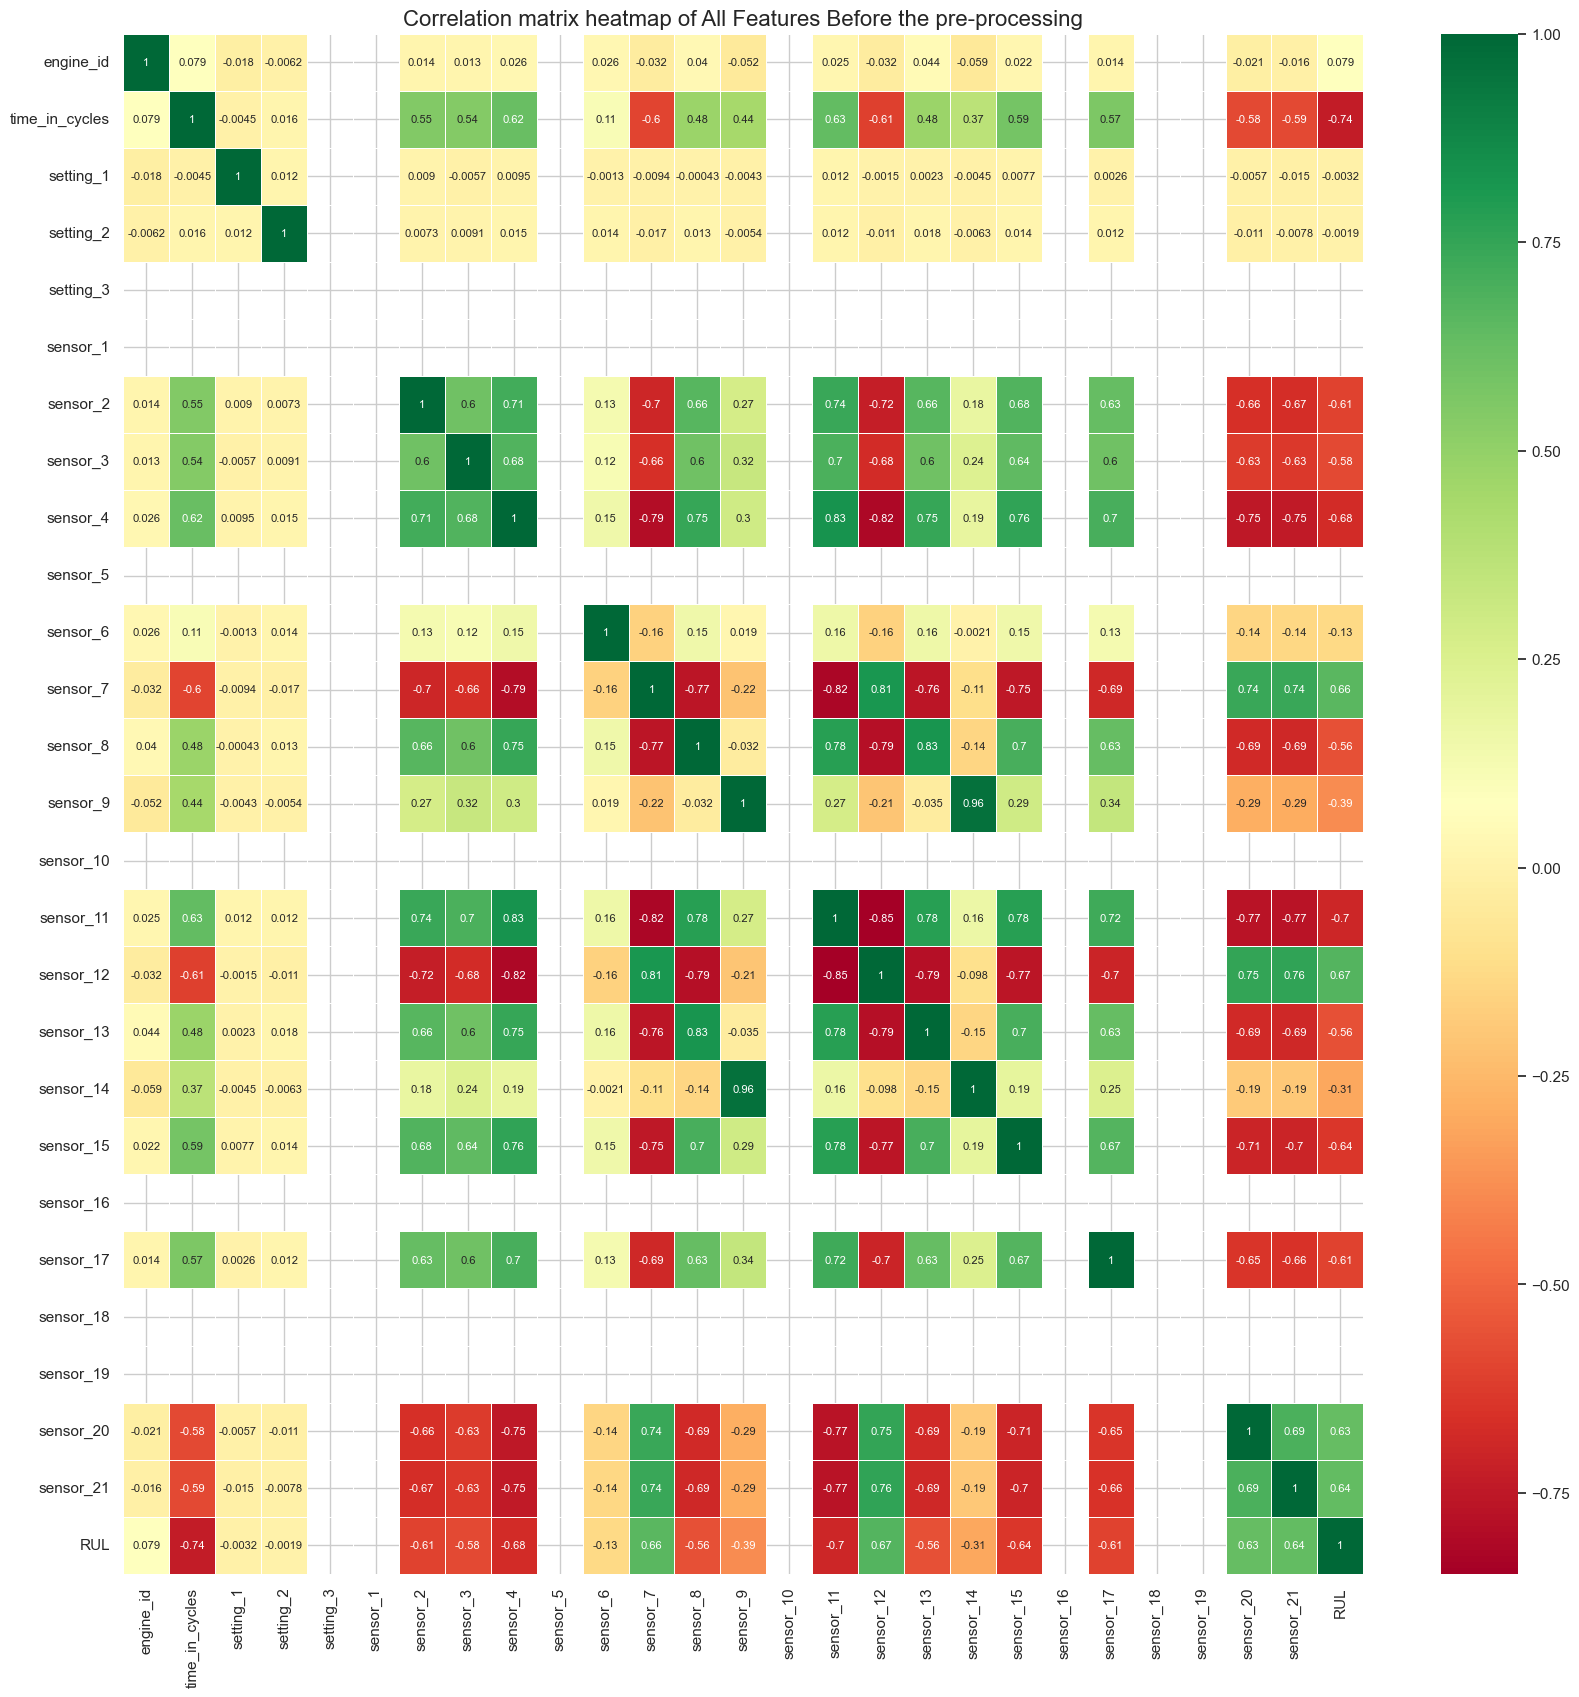

In [25]:
# Correlation matrix
corr_matrix = train_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', linewidths=.5,  annot_kws={"size": 8})
plt.title('Correlation matrix heatmap of All Features Before the pre-processing', fontsize=16)
plt.show()

Let's examine the correlation between RUL and sensors, more visually. 

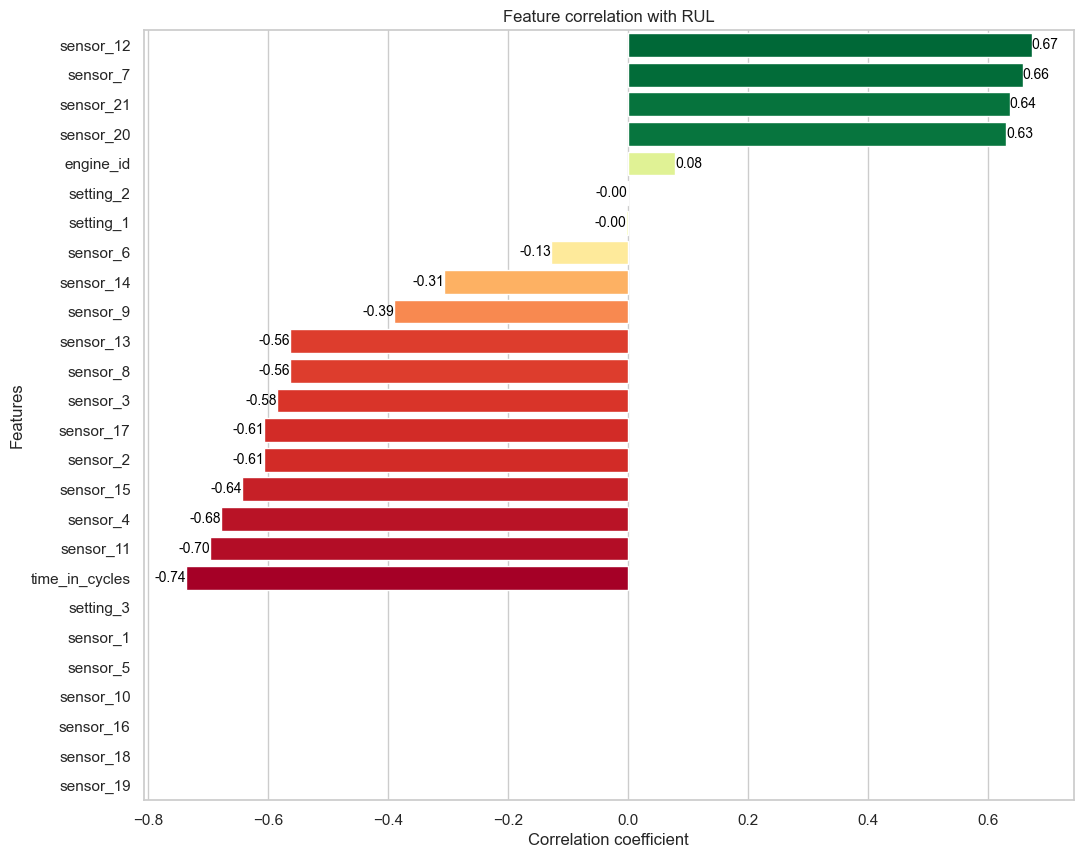

In [26]:
rul_correlations = corr_matrix['RUL'].drop('RUL').sort_values(ascending=False)

plt.figure(figsize=(12, 10))

ax = sns.barplot(x=rul_correlations.values, y=rul_correlations.index)
norm = Normalize(vmin=rul_correlations.min(), vmax=rul_correlations.max())
cmap = mpl.colormaps['RdYlGn']

bars = [p for p in ax.patches if isinstance(p, plt.Rectangle)]

for bar, value in zip(bars, rul_correlations.values):
    color = cmap(norm(value))
    bar.set_facecolor(color)
    ax.text(value, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center', 
            ha='left' if value > 0 else 'right', 
            fontsize=10,color='black',)

plt.title('Feature correlation with RUL')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

#### ⇒ Correlation Analysis & Decisions

##### - No correlation / No variance
According to the raw correlation matrix, there are clearly some **unnecessary elements** with zero variance (sensor 18 for example) that do not contribute, which we will remove later. They are also unrelated to RUL.



Based on the correlation matrix, we identified a major case regarding **sensor relationships**. We apply a strict redundancy threshold of **0.95 (95%)** to decide whether to keep or drop a feature.

##### - Extreme Multicollinearity (Sensor 9 vs. Sensor 14)
These two sensors are virtually identical in their behavior. **A 0.96 correlation exceeding 0.95** indicates that `sensor_14` provides almost no new information compared to `sensor_9`. Other correlations are stronger with `sensor_9` than `sensor_14`, so **we decide to drop `sensor_14`**. (We will delete it in the "Feature Selection: Drop Uninformative and Overcorrelated features"
Keeping both would introduce redundancy (multicollinearity), which can destabilize the SVR model and unnecessarily increase the complexity of the Random Forest without improving accuracy.

##### - High multicollinearity : (Sensor 8 vs. Sensor 13)
We can also see a strong but Distinct Correlation: 83%. While these sensors are related, a correlation of 0.83 implies that **17%** of the variance in their relationship is unique. We can keep both.

##### - RUL correlations : 
After looking at correlation between features and Remaining Useful Life (`RUL`). The analysis of the correlation matrix reveals weak predictors:

* The operational settings (`setting_1`(-0.0032), `setting_2`(-0.0019)) display negligible correlation coefficients ($|r| < 0.01$).
* `sensor_6` (-0.13) is very weak, we will delete it.

Then to reduce dimensionality and prevent noise injection, all constant sensors and weak predictors are **excluded** from the training and validation sets. 

**The model will rely exclusively on the remaining sensors that demonstrate statistically significant correlations (61%, 58%, 66%...) with the engine's remaining life.**


### b') Plotting the evolution of features (sensors with real name) along with the evolution with RUL


First, in order to have a better overview of the dataset, **let's match each sensor with its real signification**, according to the documentation.

<div style="width:100%;text-align: center;"><img src="https://i.postimg.cc/Tw0sdPKy/units1.png" width="500px" height="500px"></div>

<div style="width:100%;text-align: center;"><img src="https://i.postimg.cc/3NwcdHGt/units2.png" width="500px" height="500px"></div>

In [27]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['sensor_'+str(i)]=x
    i+=1
print ("Significations of each sensors : ")
Sensor_dictionary

Significations of each sensors : 


{'sensor_1': '(Fan inlet temperature) (◦R)',
 'sensor_2': '(LPC outlet temperature) (◦R)',
 'sensor_3': '(HPC outlet temperature) (◦R)',
 'sensor_4': '(LPT outlet temperature) (◦R)',
 'sensor_5': '(Fan inlet Pressure) (psia)',
 'sensor_6': '(bypass-duct pressure) (psia)',
 'sensor_7': '(HPC outlet pressure) (psia)',
 'sensor_8': '(Physical fan speed) (rpm)',
 'sensor_9': '(Physical core speed) (rpm)',
 'sensor_10': '(Engine pressure ratio(P50/P2)',
 'sensor_11': '(HPC outlet Static pressure) (psia)',
 'sensor_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 'sensor_13': '(Corrected fan speed) (rpm)',
 'sensor_14': '(Corrected core speed) (rpm)',
 'sensor_15': '(Bypass Ratio) ',
 'sensor_16': '(Burner fuel-air ratio)',
 'sensor_17': '(Bleed Enthalpy)',
 'sensor_18': '(Required fan speed)',
 'sensor_19': '(Required fan conversion speed)',
 'sensor_20': '(High-pressure turbines Cool air flow)',
 'sensor_21': '(Low-pressure turbines Cool air flow)'}

#### ⇒ Qualitative Analysis: Sensor Degradation Trends

To validate our feature selection physically, we visualize the temporal evolution of key sensors. The signal function displays the sensor values  against the Remaining Useful Life (RUL).


**Objectives:**
1.  **Trend Validation:** Confirm that selected high-correlation sensors show a **clear drift (monotonic increase or decrease) as the engine approaches failure (RUL $\to$ 0)**.
2.  **Uncorrelated Signal Verification:** Visually confirm that sensors identified as "non-correlated" or having low correlation coefficients exhibit flat, stable, or random behavior, thereby validating the statistical decision to consider them as non-predictive or noise.

In [28]:
def signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,3))
    for i in df['engine_id'].unique():
        if (i % 10 == 0):   
            plt.plot('RUL', signal_name, data=df[df['engine_id']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

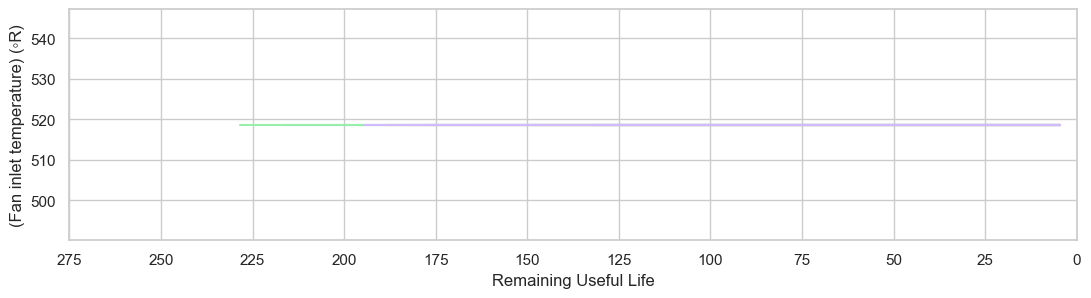

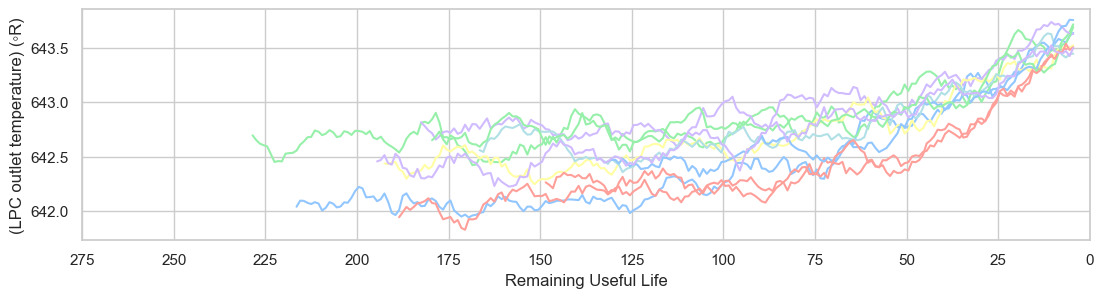

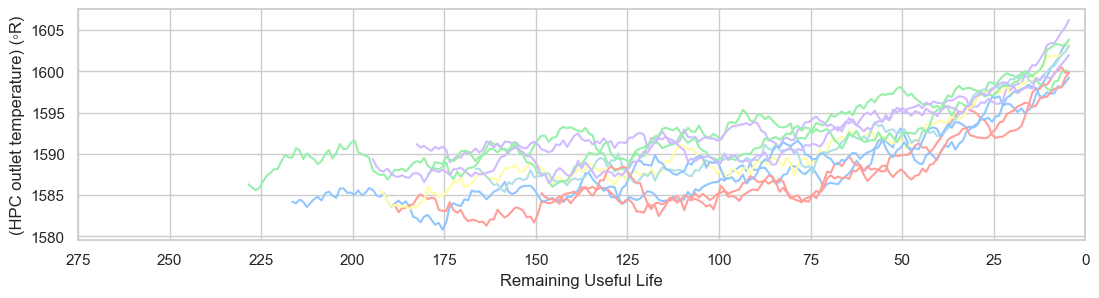

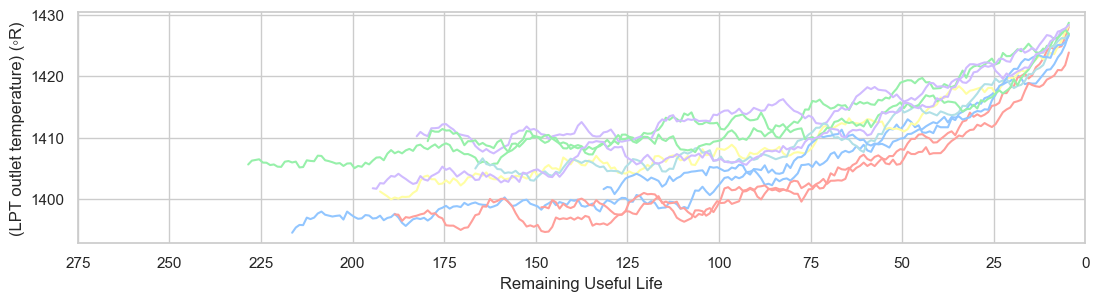

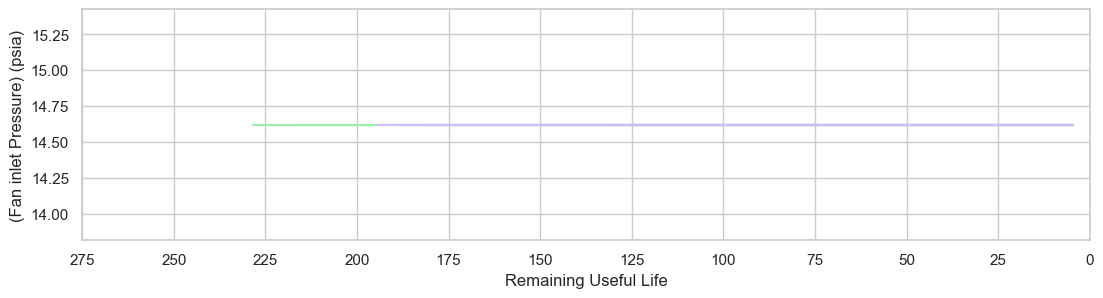

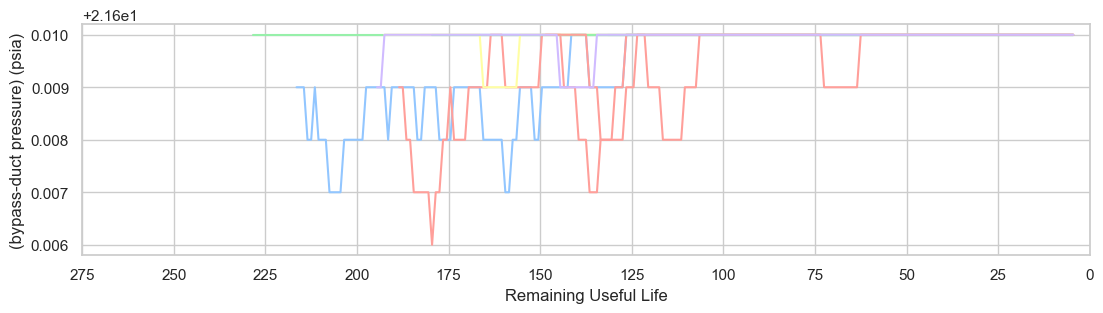

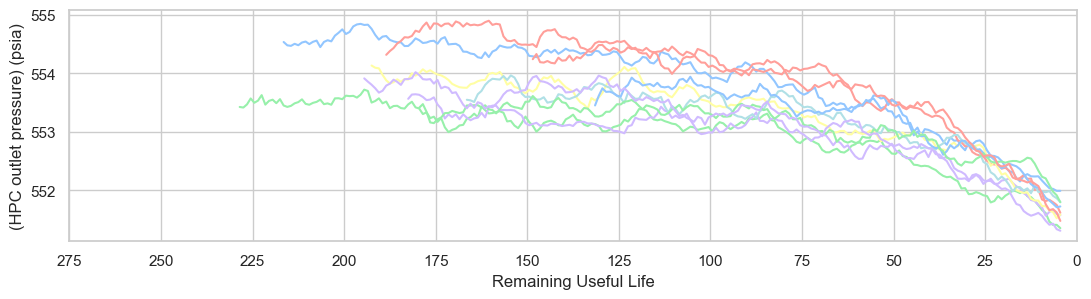

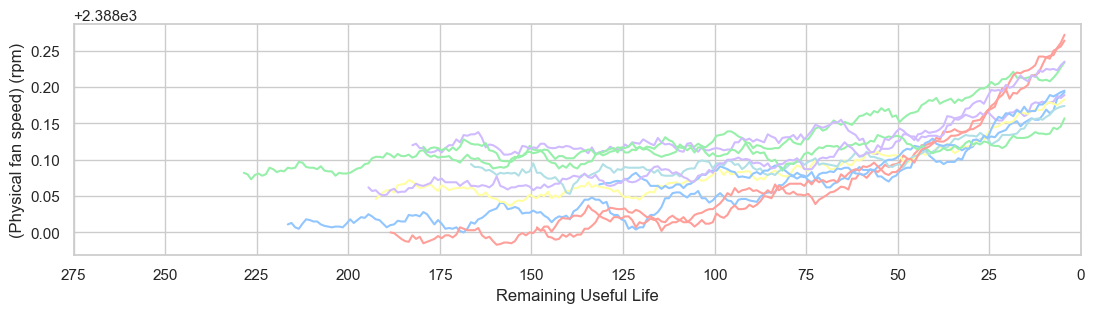

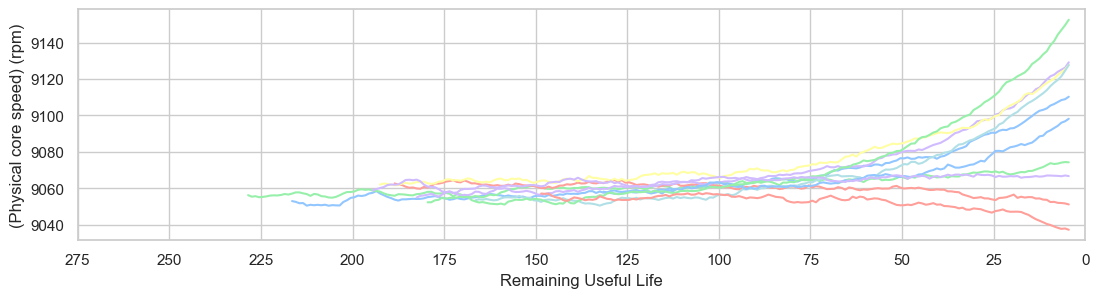

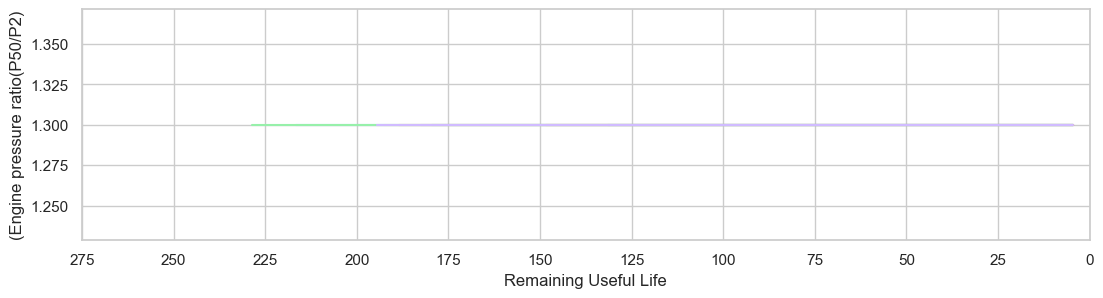

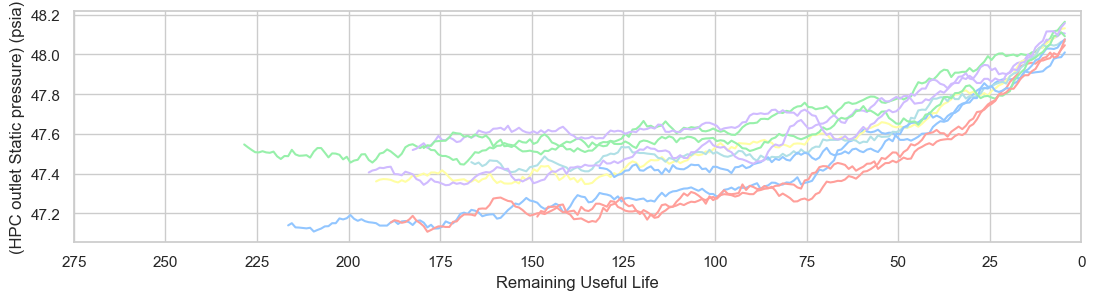

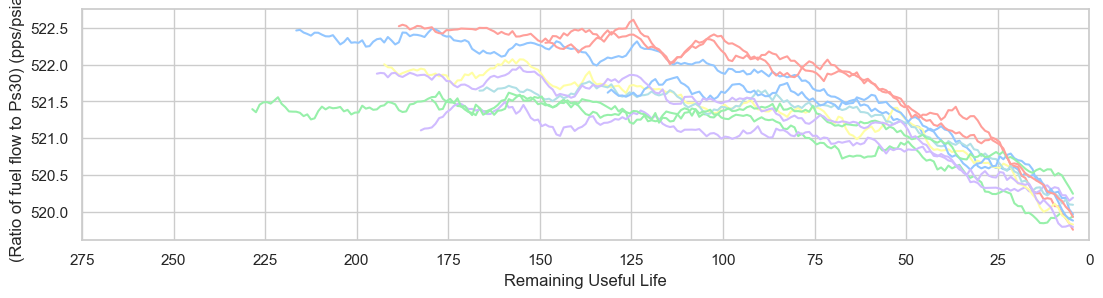

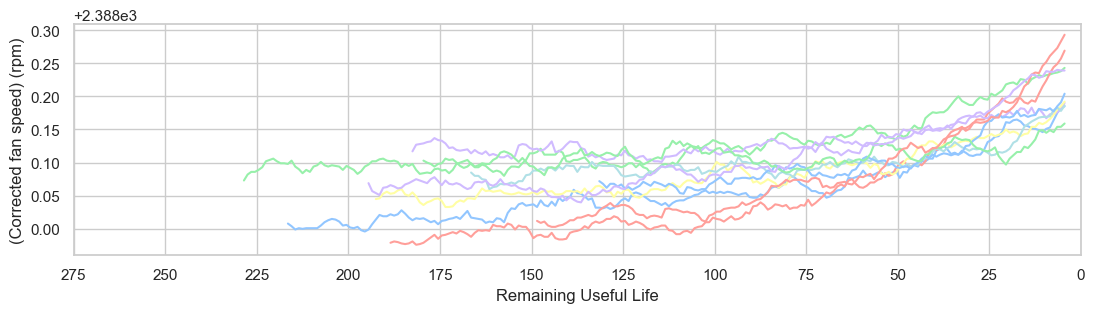

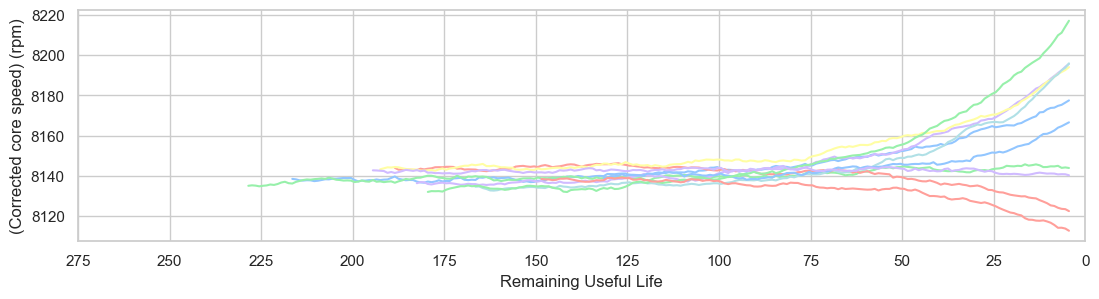

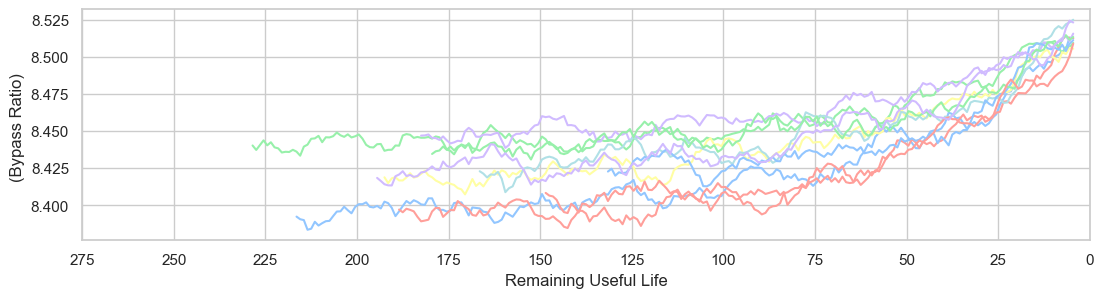

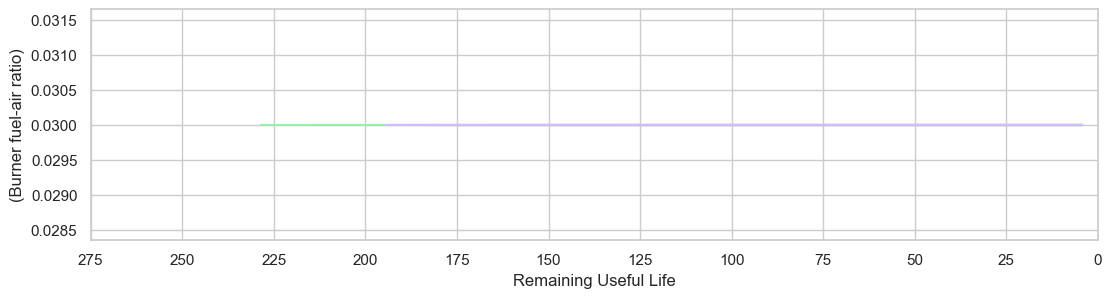

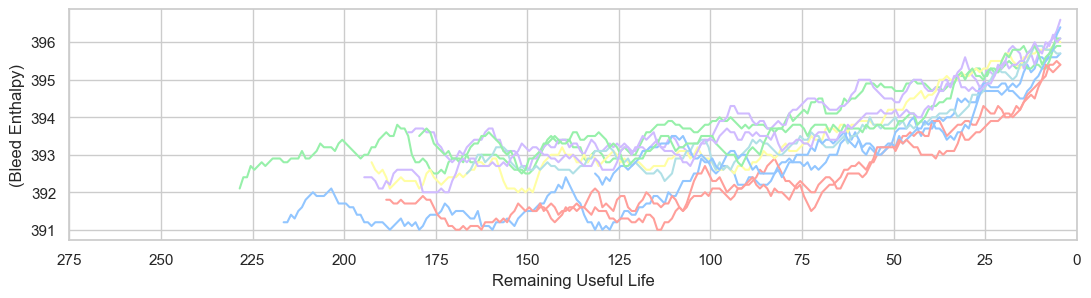

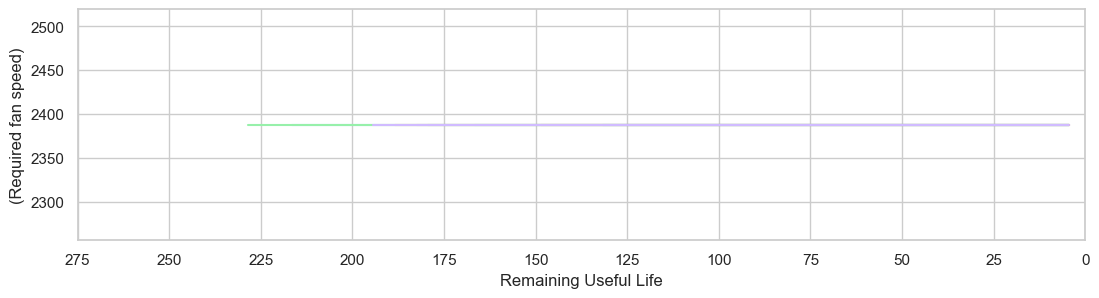

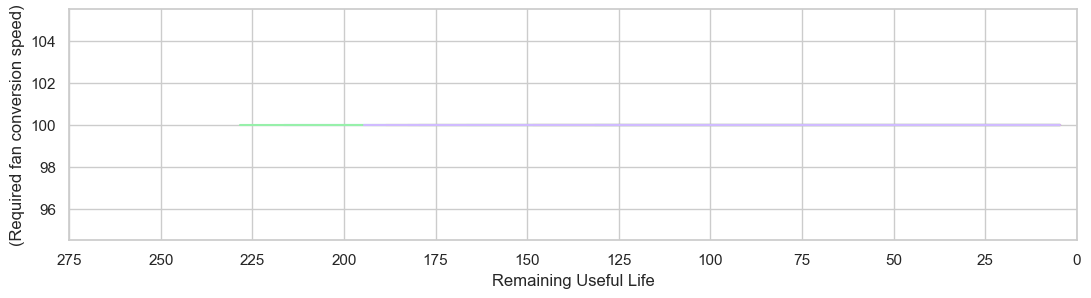

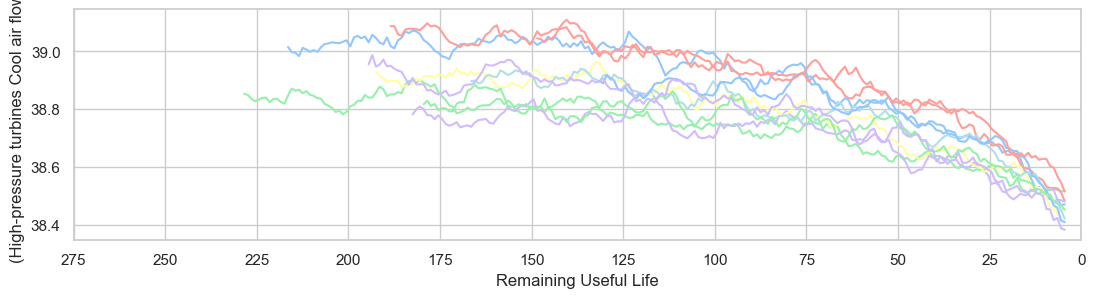

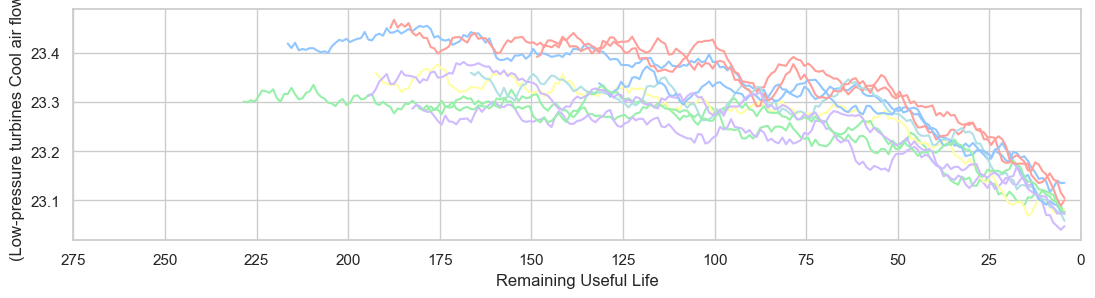

In [29]:
for i in range(1,22):
    try:
        signal(train_df, Sensor_dictionary,'sensor_'+str(i))
    except:
        pass

#### ⇒ Observations

##### 1. Data Quality & Preprocessing
* **Constant Features:** In addition to the correlation matrix, the plots confirm that sensors **1, 5, 10, 16, 18, and 19** remain constant. As they exhibit zero variance and do not influence the RUL, **we will drop these features.**
* **Scaling Requirement:** The remaining sensors are not well-distributed and contain significant **outliers**. Consequently, we must **scale** (normalize) our data to ensure model stability.

##### 2. Correlation Analysis & Physical Interpretation
* **Consistent Drift (Example : Sensor 7: HPC Outlet Pressure)**

**Corr = 0.66 (High)**. The high correlation coefficient aligns perfectly with the visual data. This sensor demonstrates a **consistent monotonic drift**, where all engine units exhibit identical behavior as they degrade. This validates the sensor as a highly reliable and stable predictor suitable for all model types.

* **Divergent Pattern (Example : Sensor 14: Corrected Core Speed)**

**Corr = -0.31 (Moderate/Low)**. The lower correlation here is explained by the visual "cancellation effect." This sensor reveals a **divergent degradation pattern** near the failure point, where specific engines follow opposing trends (some rising, others falling). This indicates heterogeneity in failure modes, which non-linear models like Random Forest are better equipped to capture compared to linear SVR.

### b'') Global Visualizations


#### (i) Maximum time cycle of each unit

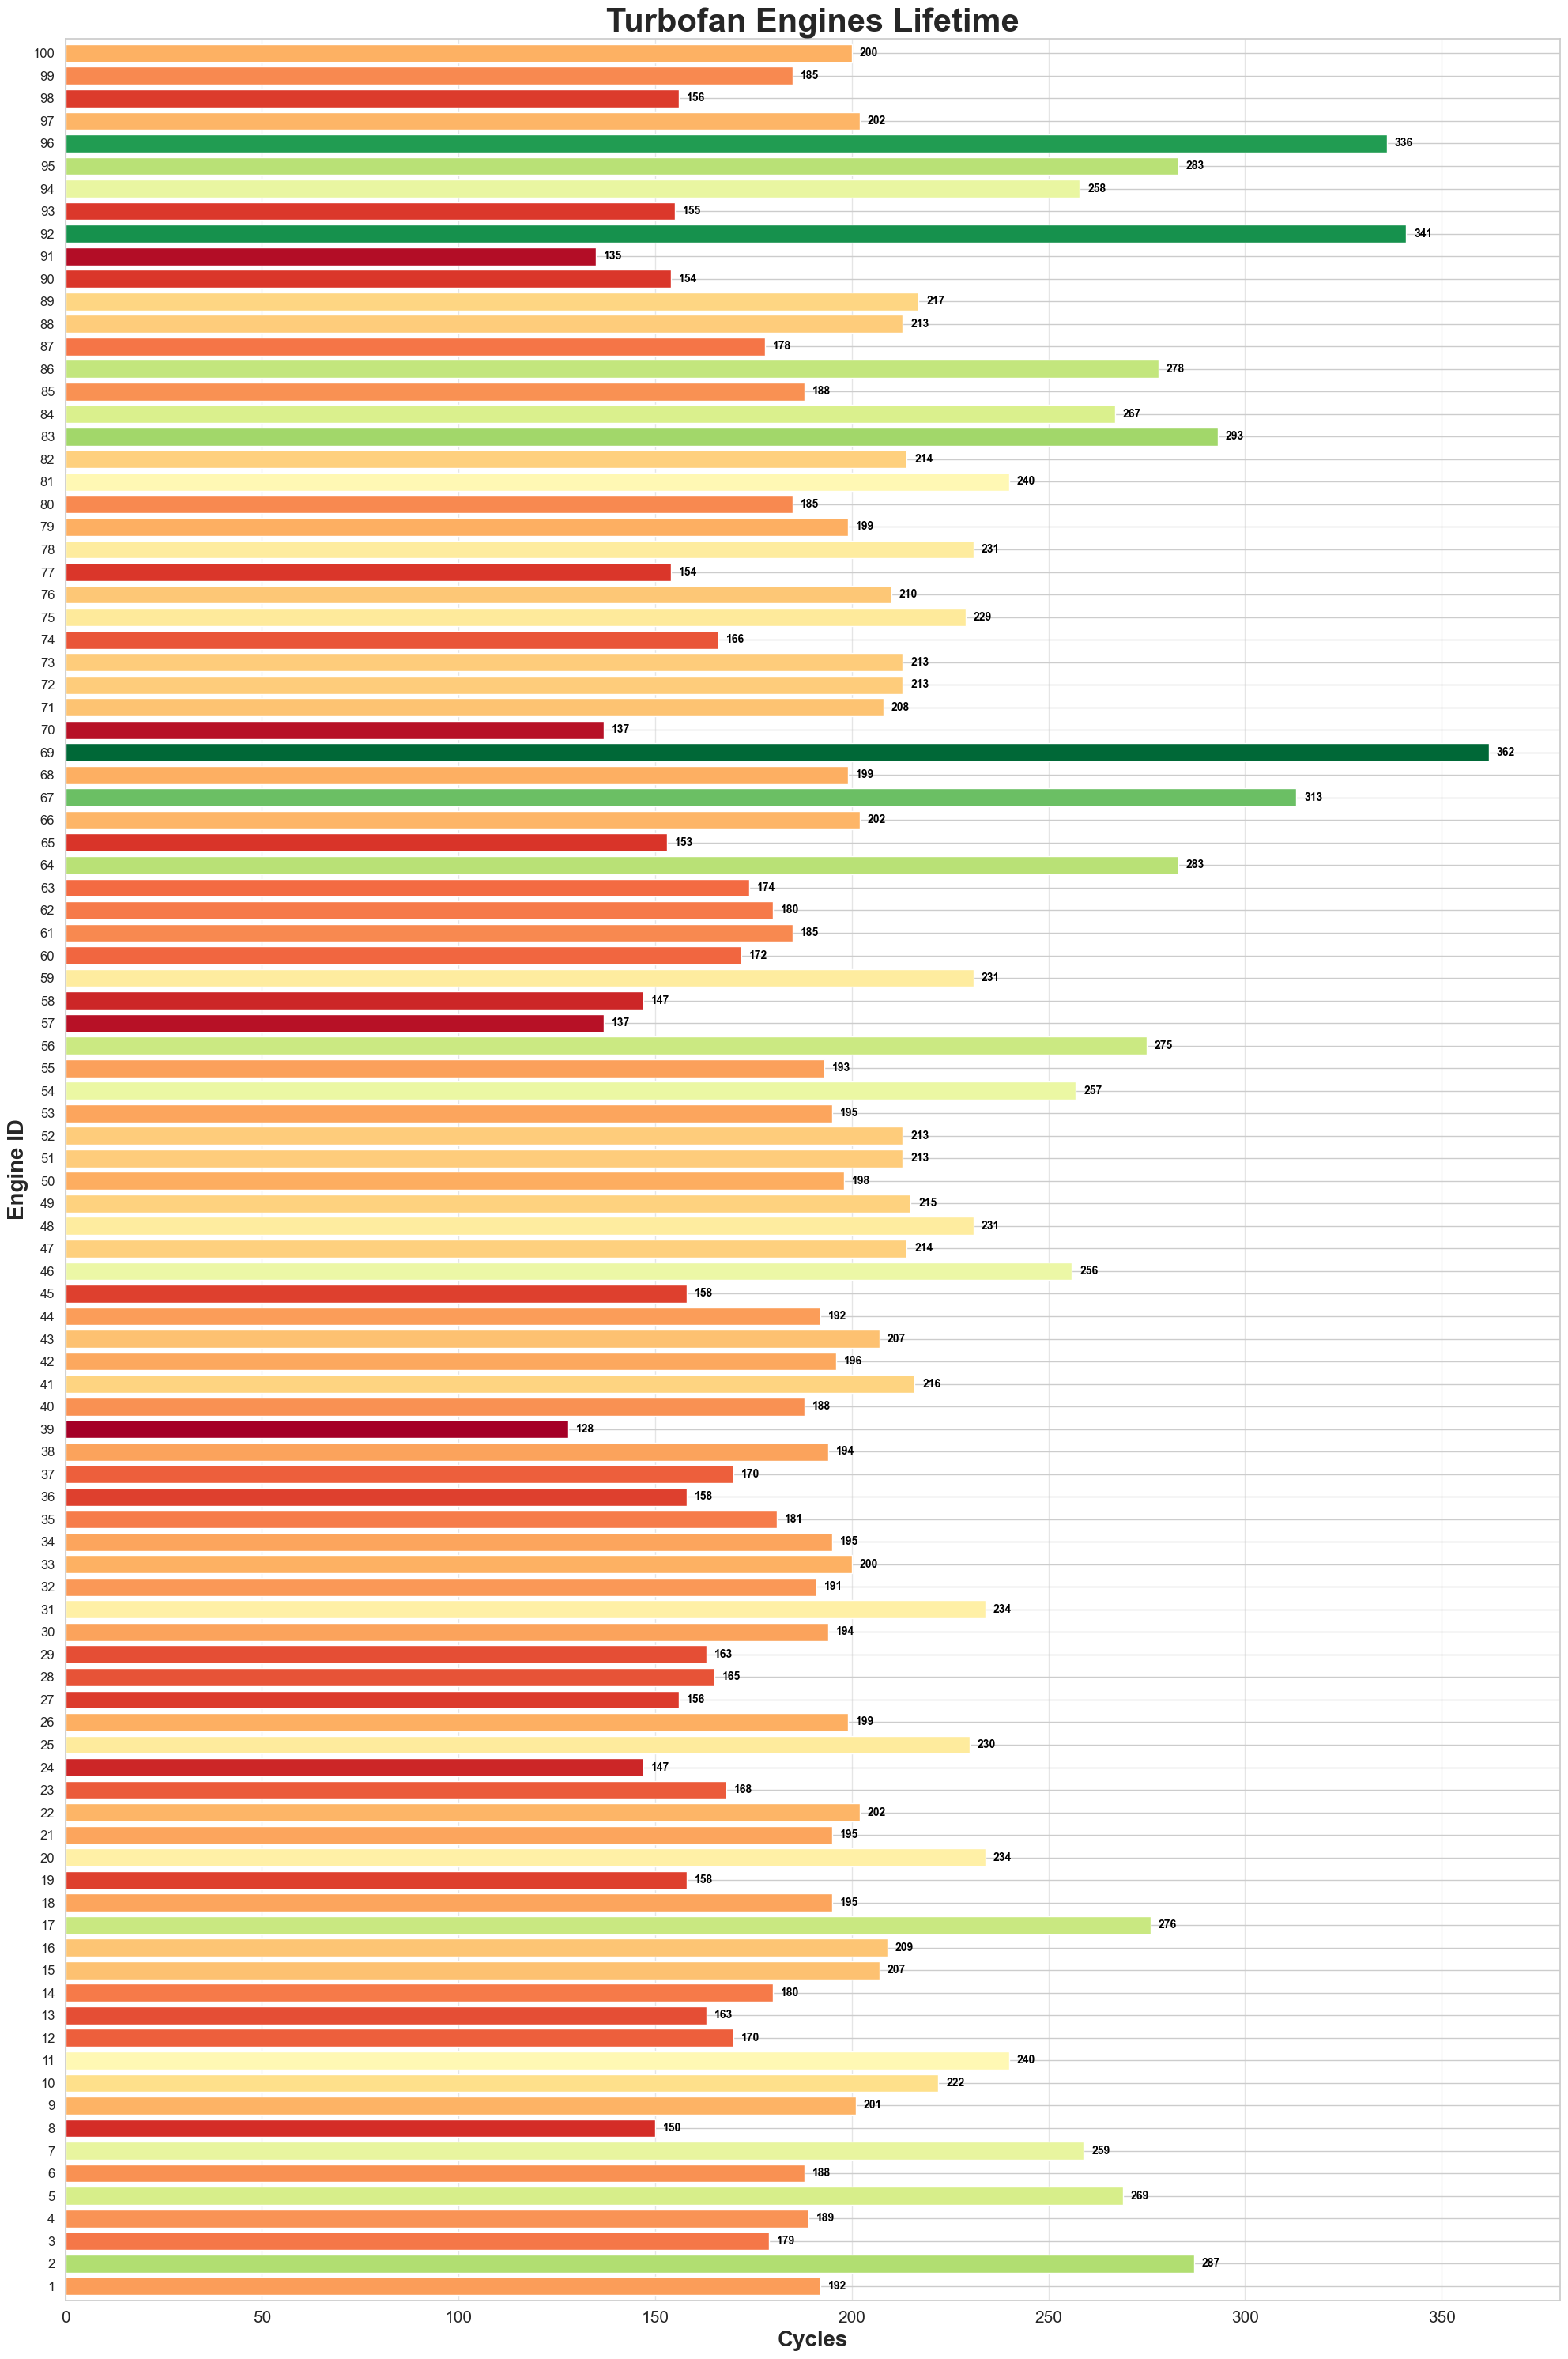

In [30]:
max_time_cycles = train_df.groupby('engine_id')['time_in_cycles'].max()

norm = mcolors.Normalize(vmin=max_time_cycles.min(), vmax=max_time_cycles.max())
cmap = plt.get_cmap('RdYlGn') 
bar_colors = cmap(norm(max_time_cycles.values))

plt.figure(figsize=(20, 30))
ax = max_time_cycles.plot(kind='barh', width=0.8, color=bar_colors)

# Add values
for i, v in enumerate(max_time_cycles):
    ax.text(v + 2, i, str(v), color='black', fontweight='bold', va='center', fontsize=10)

# Styling 
plt.title('Turbofan Engines Lifetime', fontweight='bold', size=30)
plt.xlabel('Cycles', fontweight='bold', size=20)
plt.ylabel('Engine ID', fontweight='bold', size=20)
plt.xticks(size=15)
plt.yticks(size=12)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()

plt.show()


#### ii) Distribution of Engine Lifecycles
This plot shows the operational lifespan for the engines in our training set. This visualization uses the original, unscaled cycle counts for better interpretability.

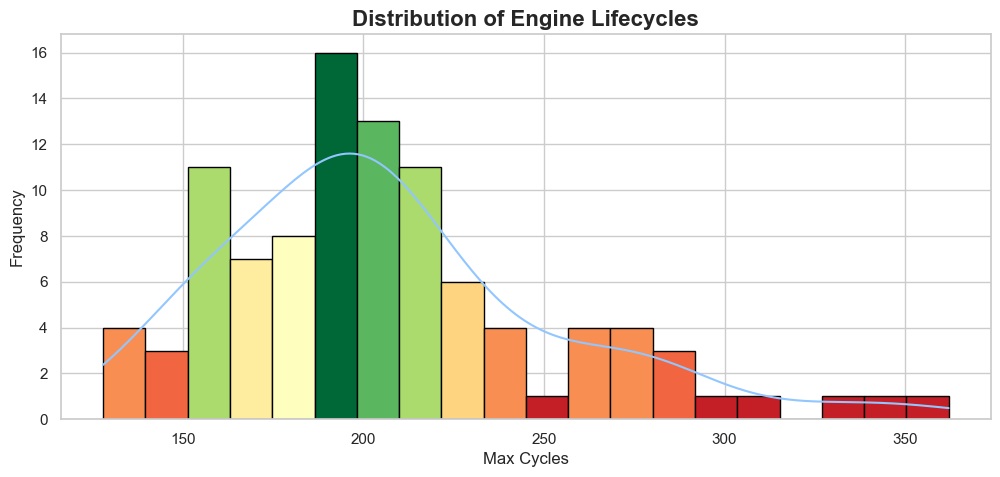

In [31]:
plt.figure(figsize=(12, 5))

ax = sns.histplot(max_cycles_df['max_cycles'], bins=20, kde=True)
bars = [p for p in ax.patches if isinstance(p, plt.Rectangle)]
heights = [p.get_height() for p in bars]

# Normalize the heights
norm = Normalize(vmin=min(heights), vmax=max(heights))

cmap = mpl.colormaps['RdYlGn'] 

# Loop through bars and set color
for bar in bars:
    color = cmap(norm(bar.get_height()))
    bar.set_facecolor(color)
    bar.set_edgecolor('black')

plt.title('Distribution of Engine Lifecycles', fontweight='bold', fontsize=16)
plt.xlabel('Max Cycles')
plt.ylabel('Frequency')
plt.show()

#### iii) Qualitative Analysis : Sensor Over Time
Let's plot some of the highly-correlated remaining sensors for a single engine (n1) to see the degradation trends.

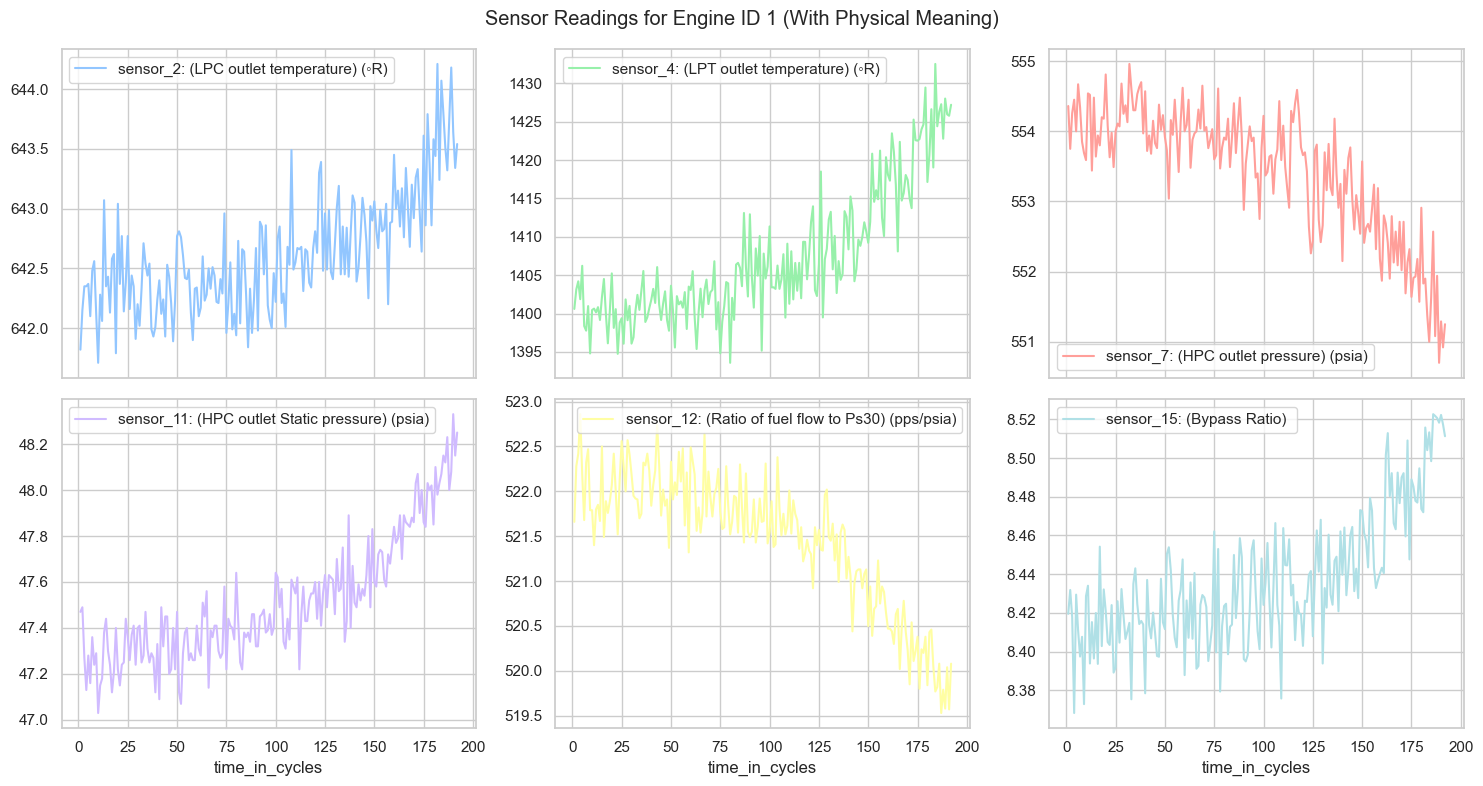

In [32]:
# 2. Select Data
engine_to_plot = train_df[train_df['engine_id'] == 1].copy() # Use .copy() to avoid SettingWithCopy warnings
sensors_to_plot = ['sensor_2', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']

# 3. Rename columns using the dictionary for the plot
# We create a new mapping specific to the sensors we want to plot
rename_map = {s: f"{s}: {Sensor_dictionary[s]}" for s in sensors_to_plot}
engine_to_plot.rename(columns=rename_map, inplace=True)

# Update the list of columns to plot to match the new names
new_sensors_to_plot = list(rename_map.values())

# 4. Create the plot
engine_to_plot.plot(
    x='time_in_cycles', 
    y=new_sensors_to_plot, 
    subplots=True, 
    layout=(2, 3), 
    figsize=(15, 8), 
    title='Sensor Readings for Engine ID 1 (With Physical Meaning)'
)

plt.tight_layout()
plt.show()

### c) Feature Selection: Drop Uninformative and Overcorrelated features
Not all features are useful. We will remove columns that have no variance (constant columns) or no significant linear relationship with the RUL. This simplifies the model and can improve performance by reducing noise. We are able to validate this numerical identification with the raw correlation matrix and the previous sensor/RUL correlation plots.

Some features are also overcorrelated as explained before, we have to delete them.

In [ ]:
# 1. Constant columns
constant_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]

# 2. Low correlation with RUL (Noise)
corr_with_rul = train_df.corr()['RUL'].abs()
low_corr_cols = corr_with_rul[corr_with_rul < 0.15].index.tolist()

# 3. Multicollinearity, which is the redundancy between features)
features_only = train_df.drop(columns=['RUL', 'RUL_clipped', 'engine_id', 'time_in_cycles'], errors='ignore')
corr_matrix_feats = features_only.corr().abs()
upper = corr_matrix_feats.where(np.triu(np.ones(corr_matrix_feats.shape), k=1).astype(bool))
redundant_cols = [column for column in upper.columns if any(upper[column] > 0.95)]

# 4. Combine and Drop
cols_to_drop = list(set(constant_cols + low_corr_cols + redundant_cols))
cols_to_drop = [c for c in cols_to_drop if c not in ['engine_id', 'RUL', 'RUL_clipped']]

train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"Dropped columns are (over-correlated / under-correlated / constant): {cols_to_drop}")
print(f"The Final shape is: {train_df.shape}")

Dropped columns (over correlated / under correlated / constant): []
Final shape: (20631, 16)


#### ⇒ Observations :
The dropped colums are indeed the same as the "no correlation" ones in the matrix or signal plots.

### d) Feature Encoding ?

No need for a categorical encoding (like One-Hot Encoding). The NASA C-MAPSS dataset consists exclusively of continuous numerical measurements (temperatures, pressures, speeds). As there are no categorical or nominal variables, techniques like One-Hot Encoding are mathematically inapplicable and unnecessary.

### e) Databalancing ?

It is important to clarify why standard **Data Balancing** techniques (such as SMOTE, Oversampling, or Undersampling) are not used in this project.

**Data Balancing** is a technique designed for **Classification** tasks where the target variable consists of discrete categories (ex Class 0 vs. Class 1). The goal is to equalize the number of samples in each class.
     **In our case:** We are performing **Regression**. Our target variable, `RUL`, is a **continuous** value (time). There are no distinct "classes" to balance. The concept of "minority class" does not exist in a continuous timeline.


### f) Target Engineering: RUL Clipping


By analyzing the sensor trajectories (specifically in the Qualitative Analysis : Sensor Degradation Trends), we observe a distinct **"Healthy Phase"** at the beginning of each engine's life. A key insight for this dataset is that engine degradation is not linear throughout the entire lifecycle. In the early stages of an engine's life, the sensor readings are stable and show no signs of wear. The degradation only becomes apparent in the later stages.

So we observe that for RUL values greater than ~125-150 cycles, sensor readings remain constant and stable.

If we use the raw, linear RUL, we force the model to predict different targets from identical sensor inputs. This creates a **weighting imbalance**: the model spends the majority of its training effort trying to distinguish between RUL 300 and RUL 200 (which is impossible due to sensor stability) rather than focusing on the critical degradation phase (RUL < 125).

To address this, we apply **RUL Clipping**. We cap the target variable at a threshold (typically 125 cycles).
* **Effect:** This effectively "rebalances" the learning process. The model treats the entire initial phase as a single constant state ("Healthy").
* **Benefit:** The loss function is no longer dominated by errors in the healthy region, allowing the algorithm to focus its optimization on the **degradation onset**, where the actual predictive value lies.

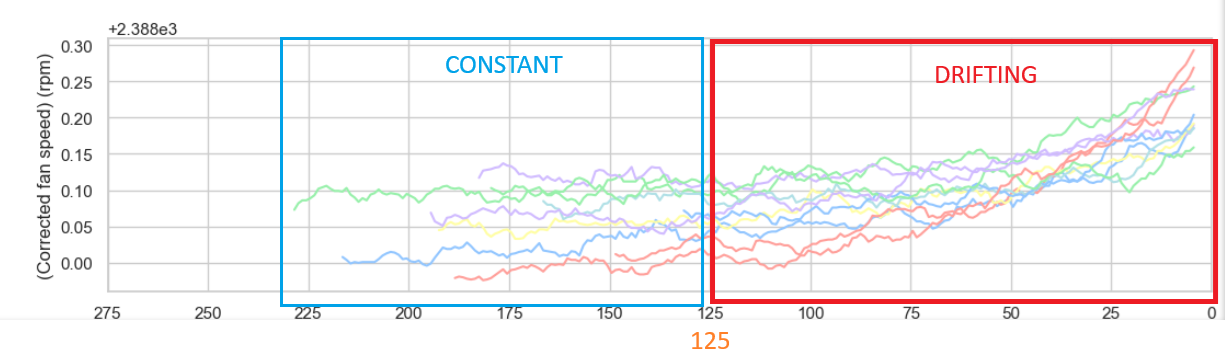

In [36]:
# Define the clipping value
Clipping_value = 125

# Clip the RUL values in the training data
train_df['RUL'] = train_df['RUL'].clip(upper=Clipping_value)

print(f"RUL values have been clipped at a maximum of {Clipping_value}.")

RUL values have been clipped at a maximum of 125.


#### Visualisation of a clipped plot (sensor_4 and sensor_7):

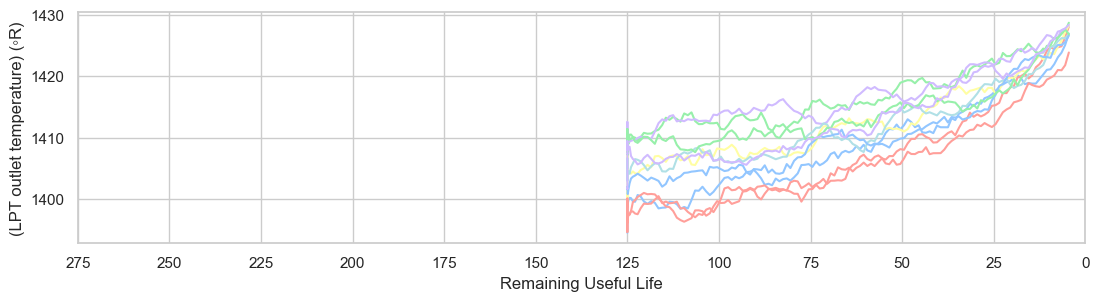

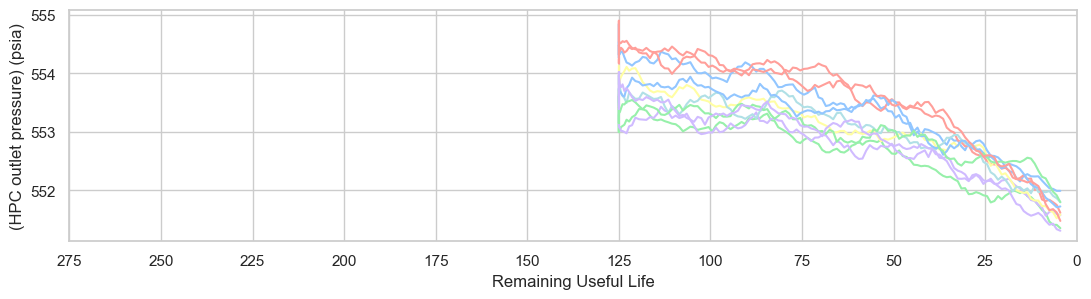

In [37]:
signal(train_df, Sensor_dictionary,'sensor_4')
signal(train_df, Sensor_dictionary,'sensor_7')

### g) Feature Scaling
Neural networks train more efficiently when input features are on a similar scale. We will use **MinMaxScaler** to scale our feature values to a range between 0 and 1.


In [ ]:
scaler = MinMaxScaler()

# These are all columns except the identifiers and the target variable
feature_cols = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL']).tolist()

# Fit the scaler on the train data and transform it with minmax
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# Transform the test data using the same fitted scaler
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

Feature scaling applied to train and test datasets.


#### Visualisation of a scaled plot (sensor_4 and sensor_7):
Values are in a range between 0 and 1.

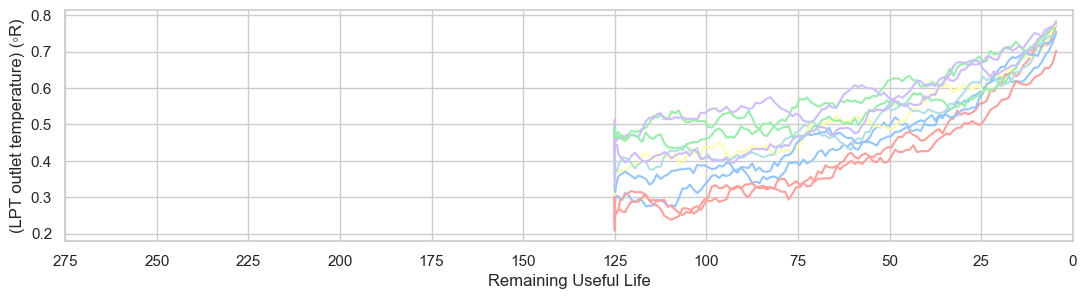

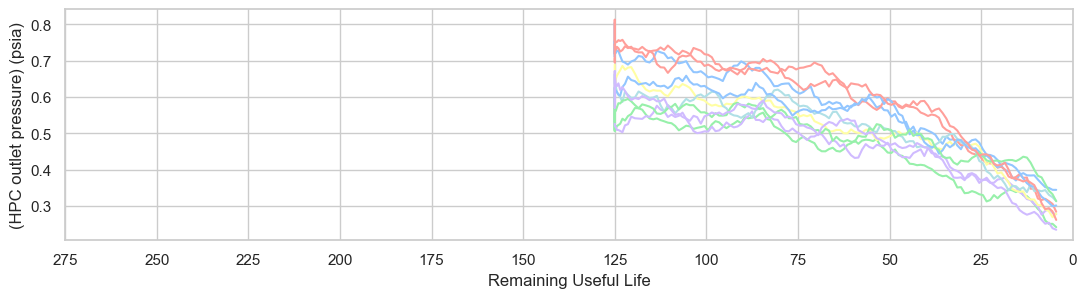

In [39]:
signal(train_df, Sensor_dictionary,'sensor_4')
signal(train_df, Sensor_dictionary,'sensor_7')

### h) PCA : Dimension reduction ?

Although Principal Component Analysis (PCA) is a standard technique in machine learning, we explicitly decided **not** to implement it in our final pipeline due to the limited dimensionality of our preprocessed dataset. After our rigorous feature selection, which removed constant sensors and non-informative operational settings, the dataset is already optimized to just **17 features**. 

**PCA is very effective for visualizing and exploring high-dimensional datasets, or data with many features.** 
So applying it in this context would yield diminishing returns. Modern algorithms such as Random Forest or LSTMs can process this concise feature set effortlessly. 

Consequently, further reducing this small number would introduce unnecessary architectural complexity without providing any tangible performance gain. We therefore proceed with the **17 selected physical features** to maximize model accuracy, preserve the physical interpretability of the sensors, and ensure that subtle degradation signals are not suppressed by variance-based projection.

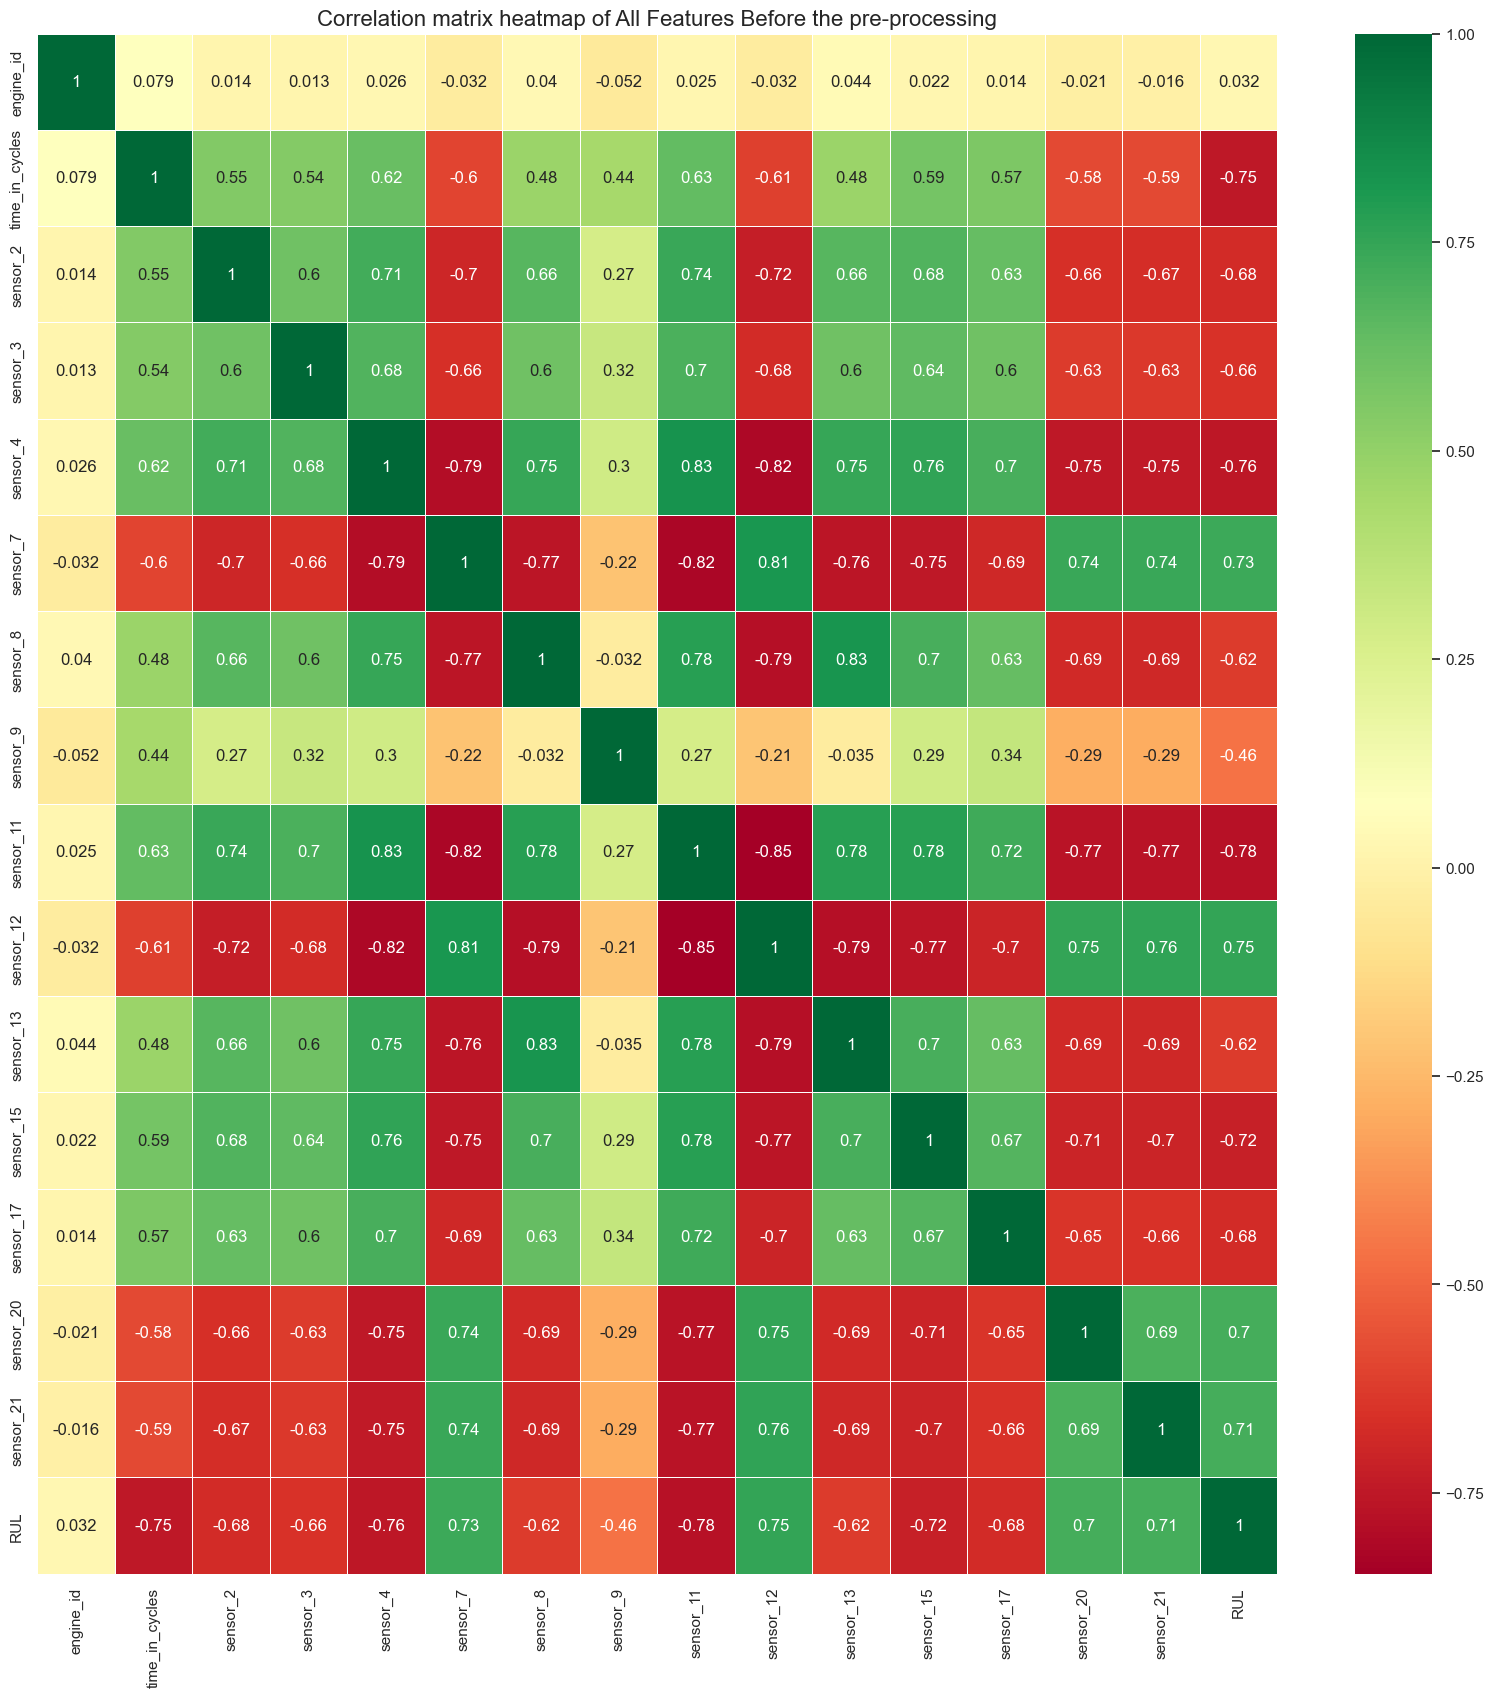

In [41]:
# Correlation matrix
corr_matrix = train_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', linewidths=.5,  annot_kws={"size": 12})
plt.title('Correlation matrix heatmap of All Features Before the pre-processing', fontsize=16)
plt.show()

# ****PART 3****. Static Model predictions

### Relevant metrics :

Let's use different metrics such as **MSE RMSE MAE R2** and **Nasa Score**. It calculates and prints the key regression metrics for Predictive Maintenance.

**MSE (Mean Squared Error)**: The average squared difference between predicted and actual values. It heavily penalizes large errors/outliers, forcing the model to fix big mistakes during training.

**RMSE (Root Mean Squared Error)**: The square root of MSE. It represents the standard error in "Cycles" (the same unit as RUL), making it the primary metric for measuring overall accuracy.

**MAE (Mean Absolute Error)**: The average absolute difference. It provides a human-readable interpretation: "On average, the model misses the prediction by X cycles."

**R² (Coefficient of Determination)**: Represents the "Goodness of Fit." A score of 0.80 means the model successfully captures 80% of the variance in the engine's degradation behavior.

**NASA Score**: The lower is better. It is an asymmetric safety metric. Unlike RMSE, it penalizes overestimation (predicting the engine is safe when it is actually failing) much more severely than underestimation (predicting early failure), prioritizing operational safety.

In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    diff = y_pred - y_true

    nasa_score = np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
    

    print(f"Performance Results for: {model_name}")
    print(f"RMSE (Root Mean Squared Error) : {rmse:.2f} cycles")
    print(f"MAE  (Mean Absolute Error)     : {mae:.2f} cycles")
    print(f"NASA Score (Cost Function)     : {nasa_score:.2f}")
    print(f"R²   (Explained Variance)      : {r2:.4f}")
    print("\n")
    
    return {'rmse': rmse, 'mae': mae, 'score': nasa_score, 'r2': r2}



Split the data into training and validation sets : 80% for training and 20% for validation

In [ ]:
features = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL'])
X = train_df[features]
y = train_df['RUL']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape is: {X_train.shape}")
print(f"Validation features shape is: {X_val.shape}")

Training features shape: (16504, 13)
Validation features shape: (4127, 13)


### Baseline Establishment: Static Machine Learning Models

Before implementing Deep Learning architectures specifically designed for time-series forecasting (such as LSTMs), we first establish a robust performance baseline using traditional "static" regression algorithms (Linear Regression, SVR, Random Forest, XGBoost).

We acknowledge that these models are theoretically suboptimal for the C-MAPSS dataset. Fundamentally, these algorithms are **time-agnostic**: they treat each flight cycle as an independent and identically distributed (i.i.d.) observation, ignoring the sequential dependencies and the historical accumulation of wear inherent to engine degradation. Even with the inclusion of rolling window features, these models remain "memoryless" regarding long-term trends.

However, implementing these models serves a critical purpose: it validates the quality of our feature engineering (scaling, RUL clipping) and provides a quantitative reference point. This allows us to strictly measure the marginal gain provided by subsequent complex neural networks, ensuring that any increase in computational cost is justified by a significant improvement in predictive accuracy.

## 1st model : Linear Regression

Using Linear Regression (Baseline)
Performance Results for: Linear Regression
RMSE (Root Mean Squared Error) : 21.75 cycles
MAE  (Mean Absolute Error)     : 17.67 cycles
NASA Score (Cost Function)     : 40847.55
R²   (Explained Variance)      : 0.7212




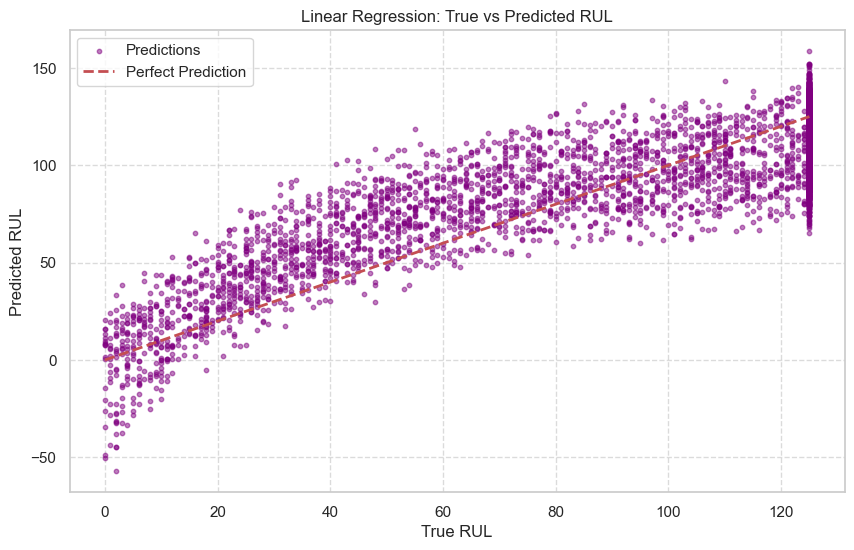

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


y_pred_lr = lr_model.predict(X_val)

metrics_lr = evaluate_model(y_val, y_pred_lr, model_name="Linear Regression")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_lr, alpha=0.5, color='purple', s=10, label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Linear Regression: True vs Predicted RUL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 2nd model : Random forest

Before building a complex deep learning model like an LSTM, it's a best practice to first create a simpler baseline model. This baseline gives us a performance benchmark; any advanced model we build must significantly outperform it to justify its complexity.

For our baseline, we will use a Random Forest Regressor. It's a powerful and robust model that works well on tabular data without requiring the complex data sequencing needed for LSTMs.

#### Data Preparation for the Baseline Model
Random Forest treats each row as an independent data point, so we don't need to create time-series sequences. We can use the data in its current tabular format. We will separate our features (X) from our target (y) and then split the training data into a new training and validation set to evaluate this model.

Training Random Forest Model
Performance Results for: Random Forest (Standard)
RMSE (Root Mean Squared Error) : 19.02 cycles
MAE  (Mean Absolute Error)     : 13.77 cycles
NASA Score (Cost Function)     : 64019.49
R²   (Explained Variance)      : 0.7869




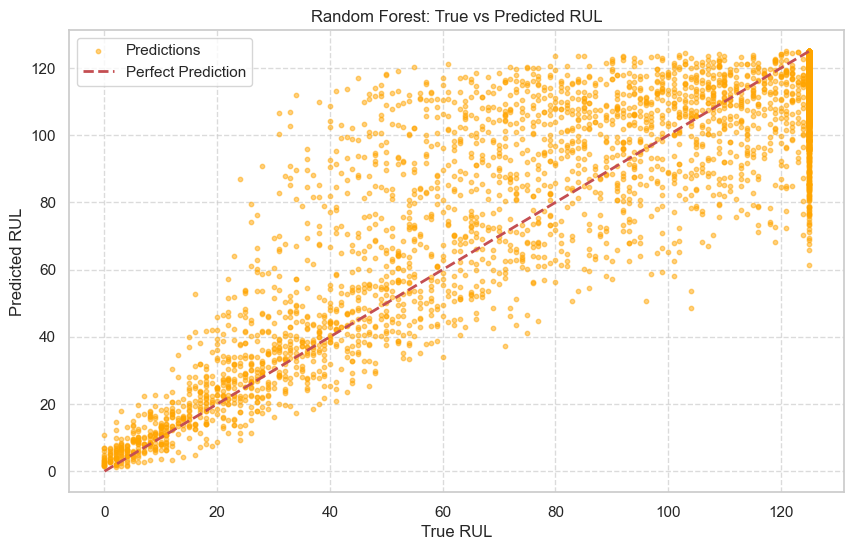

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_estimators=100 creates 100 trees

rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_val)

metrics_rf = evaluate_model(y_val, y_pred_rf, model_name="Random Forest (Standard)")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_rf, alpha=0.5, color='orange', s=10, label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Random Forest: True vs Predicted RUL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## 3rd model : SVR

--- Training SVR Model (RBF Kernel) ---
Performance Results for: SVR (RBF Kernel)
RMSE (Root Mean Squared Error) : 19.52 cycles
MAE  (Mean Absolute Error)     : 12.75 cycles
NASA Score (Cost Function)     : 109704.54
R²   (Explained Variance)      : 0.7753




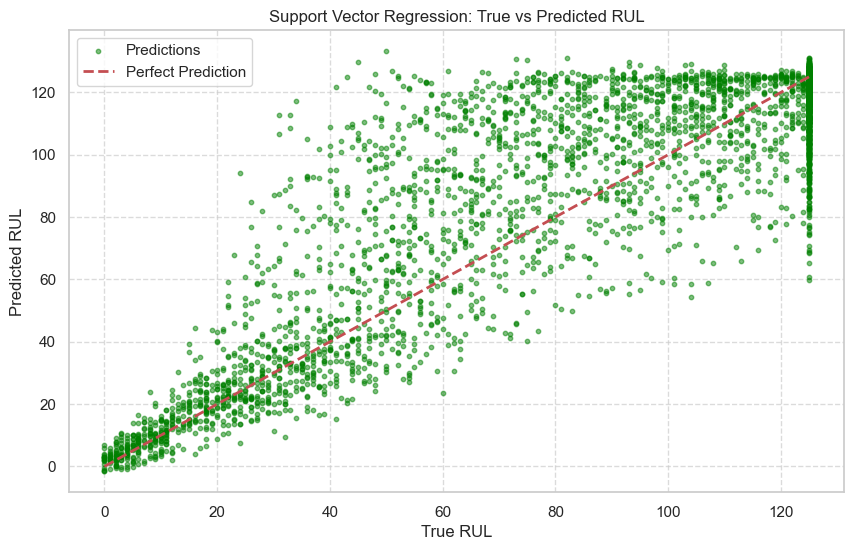

In [ ]:
svr_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)

svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_val)

metrics_svr = evaluate_model(y_val, y_pred_svr, model_name="SVR (RBF Kernel)")

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_svr, alpha=0.5, color='green', s=10, label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Support Vector Regression: True vs Predicted RUL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Conclusion on Static Models

As we can expect, and observe, the results are not satisfying enough : The costs are enormous, and we can therefore deduce that more advanced models are more suitable.  (NASA SCORE : 40000 - 100000)

### Limitations of Static Models and Transition to Deep Learning

While traditional algorithms such as Linear Regression, Support Vector Regression (SVR), and Random Forest have established a solid baseline, they suffer from a fundamental theoretical limitation in this context: they are **time-agnostic**. These models treat each time cycle as an independent, isolated sample (i.i.d), effectively ignoring the sequential nature of engine degradation. These algorithms inherently lack an internal memory state to track the historical evolution of the fault.

Consequently, to capture the complex, non-linear dynamics of engine wear over time, it is necessary to transition towards **Recurrent Neural Networks (RNNs)**. Unlike static models, these architectures process data as continuous sequences rather than isolated points. Our subsequent work will focus on implementing two specific Deep Learning architectures:

1.  **Long Short-Term Memory (LSTM):** The industry standard for Predictive Maintenance, designed to overcome the "vanishing gradient" problem. It can retain information over long sequences, allowing it to detect subtle degradation patterns that started hundreds of cycles ago.
2.  **Gated Recurrent Units (GRU):** A streamlined, efficient variant of LSTM. GRUs are particularly effective for datasets like C-MAPSS as they often achieve comparable accuracy to LSTMs while requiring less computational power and training time.

# LSTM:

In [ ]:
def create_sequences(data, target, window_size, machine_id_col):
    X_seq = []
    y_seq = []
    
    for engine in data[machine_id_col].unique():

        engine_data = data[data[machine_id_col] == engine]
        
        features = [c for c in engine_data.columns if c not in ['engine_id', 'time_in_cycles', 'RUL', 'RUL_clipped']]
        engine_features = engine_data[features].values
        
        engine_target = engine_data[target].values
        
        if len(engine_data) < window_size:
            continue
            
        for i in range(len(engine_data) - window_size):

            X_seq.append(engine_features[i : i + window_size])

            y_seq.append(engine_target[i + window_size])
            
    return np.array(X_seq), np.array(y_seq)


sequence_length = 30
target_col = 'RUL'

X_train_lstm, y_train_lstm = create_sequences(train_df, target_col, sequence_length, 'engine_id')

print(f"Original shape is: {train_df.shape}")
print(f"LSTM Input Shape is: {X_train_lstm.shape} (Samples, TimeSteps, Features)")

Reshaping Training Data for LSTM...
Original shape: (20631, 17)
LSTM Input Shape: (17631, 30, 14) -> (Samples, TimeSteps, Features)


In [ ]:
#Model architecture

model_lstm = Sequential()

# LSTM Layer 1
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2)) # Prevents overfitting

# LSTM Layer 2
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))


model_lstm.add(Dense(units=25, activation='relu'))
model_lstm.add(Dense(units=1)) # Output layer: 1 neuron (RUL prediction)


model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.summary()

C:\Users\hydra\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 100)             │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,501 (302.74 KB)

 Trainable params: 77,501 (302.74 KB)

 Non-trainable params: 0 (0.00 B)

Starting LSTM Training...
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3870.3110 - val_loss: 1839.6838
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1759.2158 - val_loss: 1790.3569
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1758.1011 - val_loss: 1801.6133
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1764.5444 - val_loss: 1795.9578
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1760.1693 - val_loss: 1804.5919
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1765.6279 - val_loss: 1805.1317
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1454.8342 - val_loss: 519.9043
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 384.0775 - val_loss: 280.6522
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 271.8480 - val_loss: 220.5372
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 256.4539 - val_loss: 198.5825
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/s

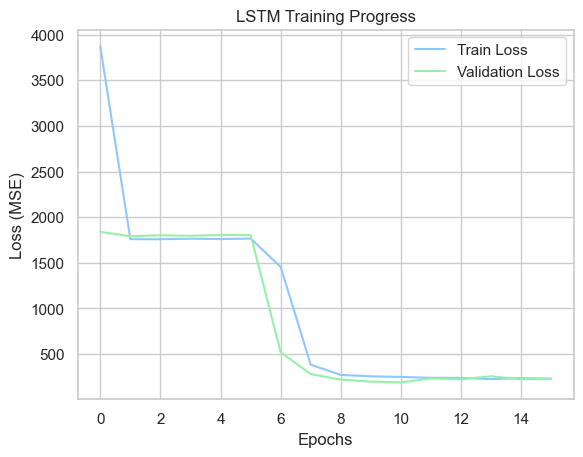

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,             
    batch_size=64,        
    validation_split=0.2, 
    callbacks=[early_stop],
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
#Prediction

def prepare_test_sequences(test_data, window_size, machine_id_col):
    X_seq_test = []
    
    for engine in test_data[machine_id_col].unique():
        engine_data = test_data[test_data[machine_id_col] == engine]
        
        features = [c for c in engine_data.columns if c not in ['engine_id', 'time_in_cycles', 'RUL', 'RUL_clipped']]
        
        if len(engine_data) >= window_size:
            last_sequence = engine_data[features].values[-window_size:]
            X_seq_test.append(last_sequence)
        else:
            pass 
            
    return np.array(X_seq_test)


X_test_lstm = prepare_test_sequences(test_df, sequence_length, 'engine_id')

print(f"Test Sequences is ready: {X_test_lstm.shape}")


y_pred_lstm = model_lstm.predict(X_test_lstm)

true_rul = pd.read_csv(rul, sep=' ', header=None)
true_rul.drop(columns=[1], inplace=True, errors='ignore')
y_true_final = true_rul.iloc[:, 0].values

if len(y_pred_lstm) == len(y_true_final):
    evaluate_model(y_true_final, y_pred_lstm.flatten(), model_name="LSTM Deep Learning")
else:
    print("Warning: Shape mismatch between prediction and truth because short sequences are skipped.")

Test Sequences Ready: (100, 30, 14)
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
Performance Report for: LSTM Deep Learning ---
RMSE (Root Mean Squared Error) : 15.38 cycles
MAE  (Mean Absolute Error)     : 11.31 cycles
NASA Score (Cost Function)     : 413.49
R²   (Explained Variance)      : 0.8630
----------------------------------------


Aligning Test Data and Truth...
Valid Engines found: 100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


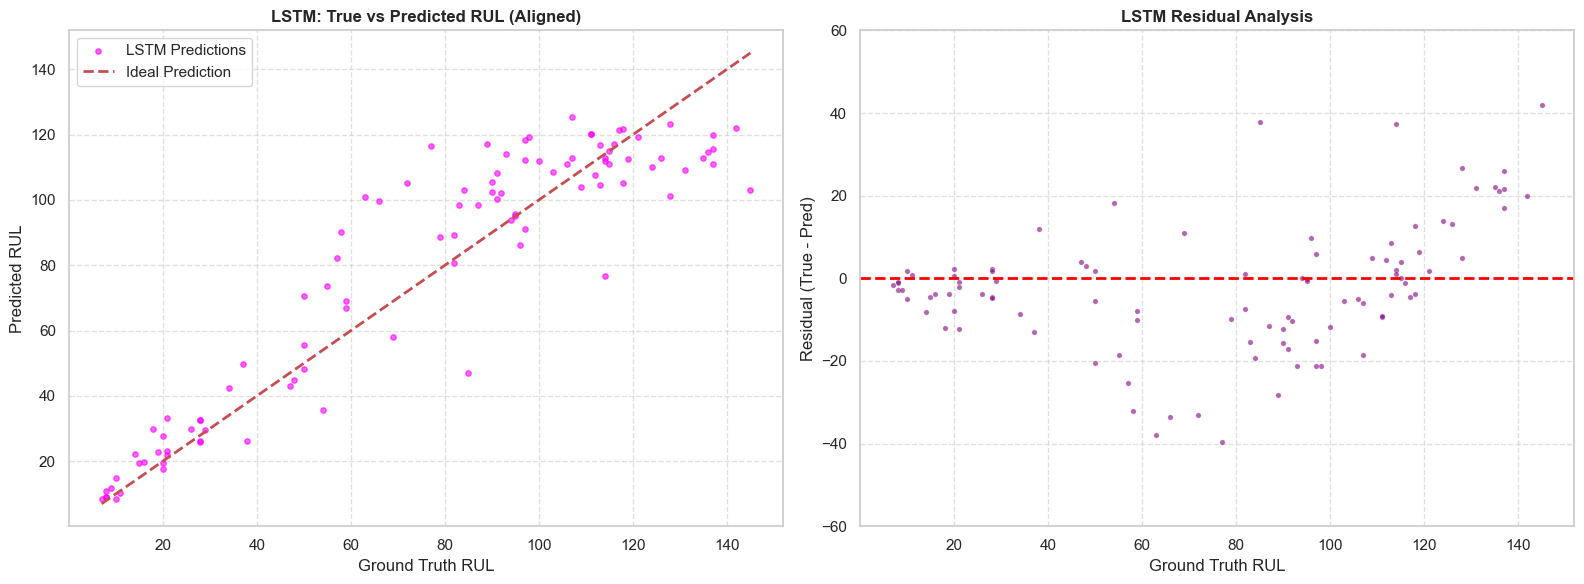

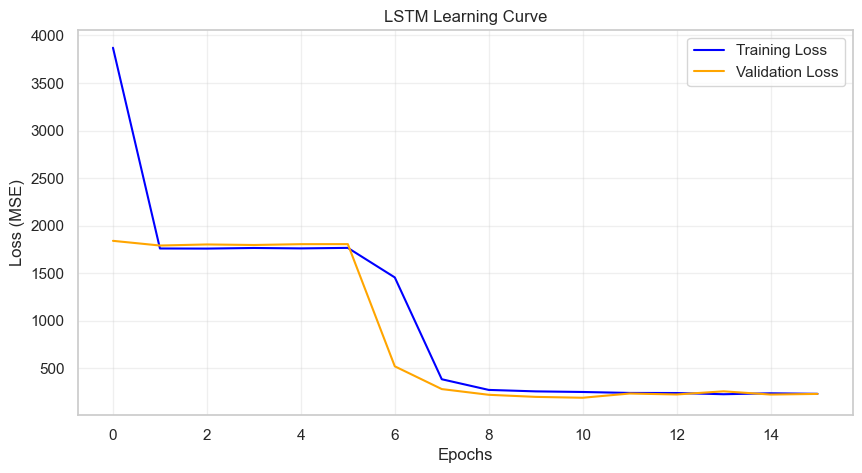

In [ ]:
def prepare_test_aligned(test_data, rul_path, window_size, machine_id_col):

    true_rul_df = pd.read_csv(rul_path, sep=' ', header=None)
    true_rul_df.drop(columns=[1], inplace=True, errors='ignore')
    raw_truth = true_rul_df.iloc[:, 0].values
    
    X_seq_test = []
    y_aligned_test = []
    

    unique_engines = test_data[machine_id_col].unique()
    
    for i, engine in enumerate(unique_engines):
        engine_data = test_data[test_data[machine_id_col] == engine]
        

        features = [c for c in engine_data.columns if c not in ['engine_id', 'time_in_cycles', 'RUL', 'RUL_clipped']]
        

        if len(engine_data) >= window_size:

            last_sequence = engine_data[features].values[-window_size:]
            X_seq_test.append(last_sequence)
            

            y_aligned_test.append(raw_truth[i])
        else:

            pass
            
    return np.array(X_seq_test), np.array(y_aligned_test)


window_size = 30 
X_test_lstm, y_true_final = prepare_test_aligned(test_df, rul, window_size, 'engine_id')

print(f"Valid Engines found: {len(y_true_final)}")


y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_true_final, y_pred_lstm, alpha=0.6, color='magenta', s=15, label='LSTM Predictions')
plt.plot([y_true_final.min(), y_true_final.max()], 
         [y_true_final.min(), y_true_final.max()], 
         'r--', lw=2, label='Ideal Prediction')

plt.title('LSTM: True vs Predicted RUL (Aligned)', fontsize=12, fontweight='bold')
plt.xlabel('Ground Truth RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


residuals = y_true_final - y_pred_lstm

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_true_final, y=residuals, alpha=0.6, color='purple', s=15)
plt.axhline(0, color='red', linestyle='--', lw=2)

plt.title('LSTM Residual Analysis', fontsize=12, fontweight='bold')
plt.xlabel('Ground Truth RUL')
plt.ylabel('Residual (True - Pred)')
plt.ylim(-60, 60)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('LSTM Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# We display the metrics (RMSE, R2, NASA Score)
metrics_lstm = evaluate_model(y_true_final, y_pred_lstm, model_name="LSTM Final Evaluation")

# Verification of performance thresholds
if metrics_lstm['rmse'] < 20:
    print(f"RMSE Excellent: {metrics_lstm['rmse']:.2f}")
else:
    print(f"RMSE à améliorer: {metrics_lstm['rmse']:.2f}")

if metrics_lstm['score'] < 500:
    print(f"NASA Score Excellent: {metrics_lstm['score']:.2f}")
else:
    print(f"NASA Score élevé: {metrics_lstm['score']:.2f}")

Performance Report for: LSTM Final Evaluation ---
RMSE (Root Mean Squared Error) : 15.38 cycles
MAE  (Mean Absolute Error)     : 11.31 cycles
NASA Score (Cost Function)     : 413.49
R²   (Explained Variance)      : 0.8630
----------------------------------------
✅ RMSE Excellent: 15.38
✅ NASA Score Excellent: 413.49


Making predictions with LSTM...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


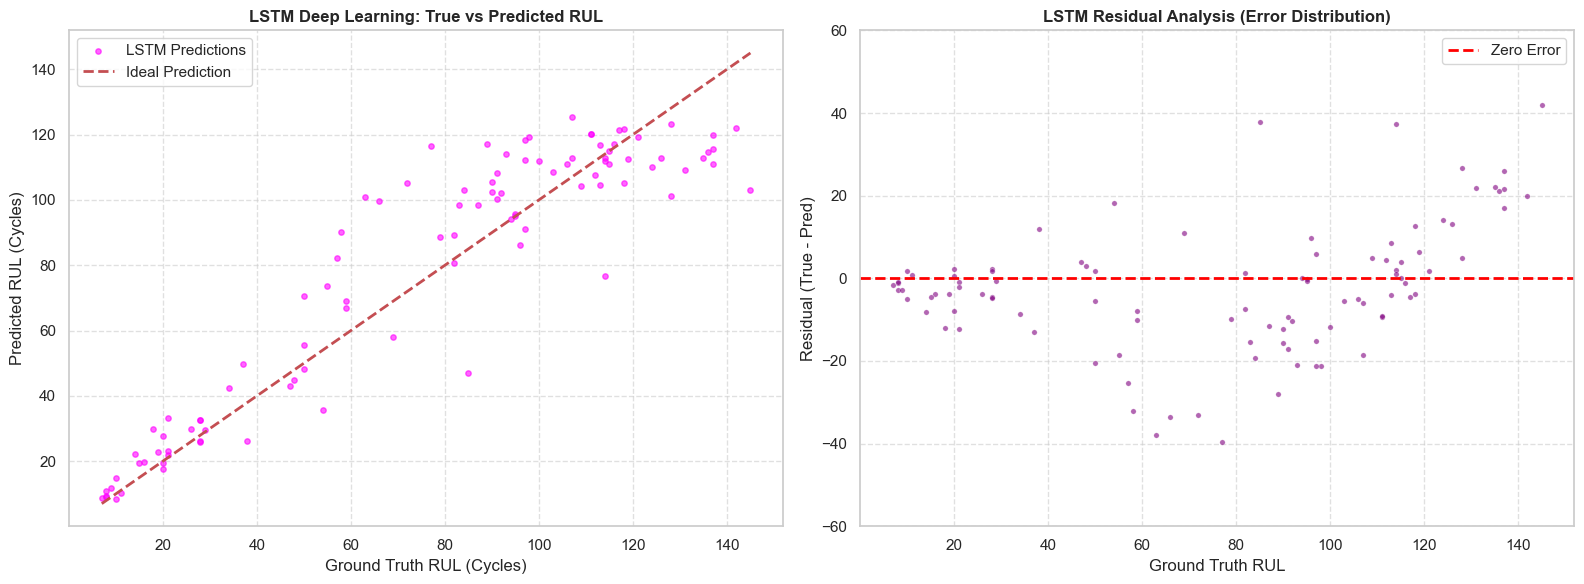

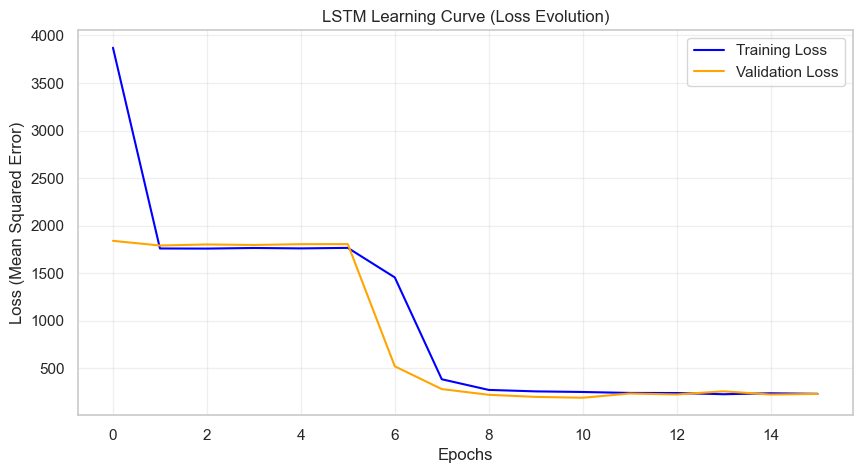

In [ ]:
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten() # Flatten 2D output to 1D array

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_true_final, y_pred_lstm, alpha=0.6, color='magenta', s=15, label='LSTM Predictions')


plt.plot([y_true_final.min(), y_true_final.max()], 
         [y_true_final.min(), y_true_final.max()], 
         'r--', lw=2, label='Ideal Prediction')

plt.title('LSTM Deep Learning: True vs Predicted RUL', fontsize=12, fontweight='bold')
plt.xlabel('Ground Truth RUL (Cycles)')
plt.ylabel('Predicted RUL (Cycles)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


residuals = y_true_final - y_pred_lstm

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_true_final, y=residuals, alpha=0.6, color='purple', s=15)
plt.axhline(0, color='red', linestyle='--', lw=2, label='Zero Error')

plt.title('LSTM Residual Analysis (Error Distribution)', fontsize=12, fontweight='bold')
plt.xlabel('Ground Truth RUL')
plt.ylabel('Residual (True - Pred)')
plt.legend()
plt.ylim(-60, 60)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


if 'history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    
    plt.title('LSTM Learning Curve (Loss Evolution)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Training history not found. Thus, we run model.fit() to generate the learning curve.")

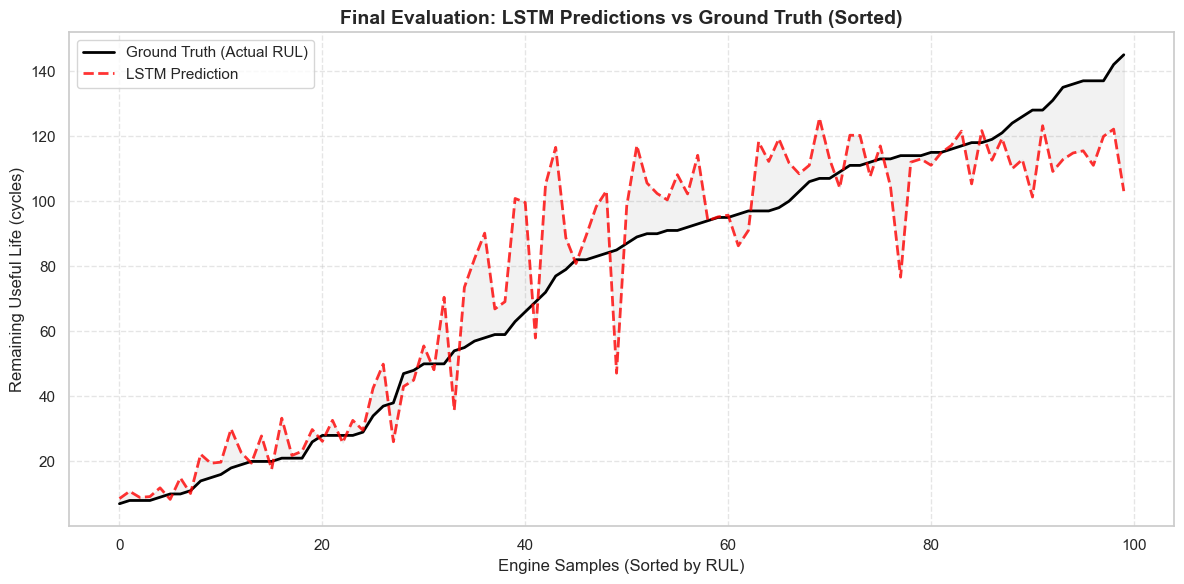

In [ ]:
#Visualization

results_df = pd.DataFrame({
    'True_RUL': y_true_final,
    'Pred_RUL': y_pred_lstm
})


results_df.sort_values(by='True_RUL', inplace=True)
results_df.reset_index(drop=True, inplace=True)


plt.figure(figsize=(12, 6))


plt.plot(results_df['True_RUL'], color='black', linewidth=2, label='Ground Truth (Actual RUL)')


plt.plot(results_df['Pred_RUL'], color='red', linestyle='--', linewidth=2, alpha=0.8, label='LSTM Prediction')


plt.title('Final Evaluation: LSTM Predictions vs Ground Truth (Sorted)', fontsize=14, fontweight='bold')
plt.xlabel('Engine Samples (Sorted by RUL)')
plt.ylabel('Remaining Useful Life (cycles)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


plt.fill_between(results_df.index, results_df['True_RUL'], results_df['Pred_RUL'], color='gray', alpha=0.1)

plt.tight_layout()
plt.show()

In [ ]:
#Function to prepare test data
def prepare_test_sequences(test_data, window_size, machine_id_col):
    X_seq_test = []
    # On itère sur chaque moteur
    for engine in test_data[machine_id_col].unique():
        engine_data = test_data[test_data[machine_id_col] == engine]
        
        features = [c for c in engine_data.columns if c not in ['engine_id', 'time_in_cycles', 'RUL', 'RUL_clipped']]
        
        if len(engine_data) >= window_size:
            last_sequence = engine_data[features].values[-window_size:]
            X_seq_test.append(last_sequence)
        else:
            pass
            
    return np.array(X_seq_test)


if 'X_test_lstm' not in locals():
    X_test_lstm = prepare_test_sequences(test_df, sequence_length, 'engine_id')

y_pred_tuned = best_model.predict(X_test_lstm).flatten()


true_rul = pd.read_csv(rul, sep=' ', header=None)
true_rul.drop(columns=[1], inplace=True, errors='ignore')
y_true_final = true_rul.iloc[:, 0].values


evaluate_model(y_true_final, y_pred_tuned, model_name="LSTM Tuned (Keras Tuner)")

# This part is for visualization
results_lstm = pd.DataFrame({'True': y_true_final, 'Pred': y_pred_tuned})
results_lstm.sort_values(by='True', inplace=True)
results_lstm.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(results_lstm['True'], color='black', label='Ground Truth')
plt.plot(results_lstm['Pred'], color='purple', linestyle='--', label='LSTM Tuned Prediction')
plt.fill_between(results_lstm.index, results_lstm['True'], results_lstm['Pred'], color='gray', alpha=0.1)
plt.title('Final Exam: LSTM Tuned vs Truth (Sorted)')
plt.legend()
plt.show()

Preparing Test Sequences...


NameError: name 'test_df' is not defined

# FIN TEMPORAIRE